In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import random
import pickle
import dataframe_image as dfi

from itertools import product
from IPython.display import clear_output

#from Data_Loading import *

import tensorflow as tf
from tensorflow import keras
import pydot

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer, StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer, r2_score, mean_absolute_percentage_error



# Importação dos Dados

Neste bloco é feita a importação do banco de dados de atributos armazenado em `atributos_main.csv` e as últimas fases de adequação do banco:
 - É criada a coluna `filepath` contendo o caminho do arquivo ao invés de apenas o nome;
 - O banco é indexado segundo o banco de dados e o nome do arquivo;
 - Os valores de andamento são arredondados para múltiplos inteiros de 0.5

Por último o banco é impresso para visualização

In [3]:
main_df = pd.read_csv('Banco de Dados/atributos/atributos_main.csv', index_col=0)
main_df['filepath'] = main_df['database']+'/'+main_df['filename']
main_df = main_df.set_index(['database', 'filename'])
main_df['bpm'] = main_df['bpm'].apply(lambda bpm: round(bpm*2)/2)
#dfi.export(main_df.iloc[:100, :10], 'atributos.png')
main_df

v_eta_A5  v_eta_D5  v_eta_D4  v_eta_D3  v_eta_D2  \
database  filename                                                              
acm_mirum 10118334.clip.mp3  2.833333  2.200000  3.181818  2.354839  4.593750   
          10258351.clip.mp3  2.266667  3.200000  2.615385  3.227273  3.617284   
          10270809.clip.mp3  2.285714  2.266667  2.692308  2.147059  3.945946   
          10332517.clip.mp3  2.666667  2.666667  2.500000  2.920000  2.940000   
          10348303.clip.mp3  3.090909  2.266667  4.125000  3.041667  3.945946   
...                               ...       ...       ...       ...       ...   
banco1    95.wav             3.750000  2.538462  3.000000  3.736842  3.918919   
          96.wav             2.833333  2.428571  2.571429  2.117647  4.264706   
          97.wav             2.428571  2.125000  2.428571  2.117647  4.235294   
          98.wav             3.000000  2.538462  2.916667  3.476190  4.424242   
          99.wav             3.500000  2.428571  2.916667  3.136364  3.106383   

                             v_eta_D1  v_sigma_A5  v_sigma_D5  v_sigma_D4  \
database  filename                                                          
acm_mirum 10118334.clip.mp3  9.187500    1.213352    0.400000    0.574960   
          10258351.clip.mp3  6.444444    0.442217    0.748331    0.624926   
          10270809.clip.mp3  7.891892    0.699854    0.442217    0.461538   
          10332517.clip.mp3  3.959459    0.471405    0.471405    0.731925   
          10348303.clip.mp3  5.192982    0.995859    0.442217    1.964529   
...                               ...         ...         ...         ...   
banco1    95.wav             5.745098    0.433013    0.745797    0.852803   
          96.wav             8.500000    1.067187    0.494872    0.622700   
          97.wav             6.125000    0.728431    0.330719    0.728431   
          98.wav             8.314286    0.632456    1.082404    0.862007   
          99.wav             5.214286    0.500000    0.728431    0.953794   

                             v_sigma_D3  ...   v_sd_D2   v_sd_D1   v_sf_A5  \
database  filename                       ...                                 
acm_mirum 10118334.clip.mp3    0.649982  ... -0.023721 -0.007043  0.721463   
          10258351.clip.mp3    0.419070  ... -0.040796 -0.040910  0.720558   
          10270809.clip.mp3    0.493031  ... -0.062429 -0.056861  0.716342   
          10332517.clip.mp3    0.271293  ... -0.058653 -0.053484  0.650508   
          10348303.clip.mp3    1.059841  ... -0.040350 -0.025611  0.573808   
...                                 ...  ...       ...       ...       ...   
banco1    95.wav               0.440347  ... -0.054363 -0.037688  0.519931   
          96.wav               0.322190  ... -0.062304 -0.055434  0.683548   
          97.wav               0.322190  ... -0.032933 -0.038682  0.693360   
          98.wav               1.219643  ... -0.033274 -0.017450  0.705853   
          99.wav               0.919261  ... -0.072486 -0.047873  0.698925   

                              v_sf_D5   v_sf_D4   v_sf_D3   v_sf_D2   v_sf_D1  \
database  filename                                                              
acm_mirum 10118334.clip.mp3  0.690003  0.710161  0.501041  0.604924  0.308860   
          10258351.clip.mp3  0.762754  0.526791  0.331555  0.290153  0.160497   
          10270809.clip.mp3  0.614350  0.502162  0.446977  0.412124  0.292314   
          10332517.clip.mp3  0.615221  0.558058  0.446767  0.445115  0.247787   
          10348303.clip.mp3  0.692712  0.567320  0.689657  0.614103  0.408099   
...                               ...       ...       ...       ...       ...   
banco1    95.wav             0.647449  0.496156  0.437015  0.530072  0.344177   
          96.wav             0.706678  0.632906  0.421532  0.384137  0.314319   
          97.wav             0.691660  0.717247  0.418132  0.331272  0.216553   
          98.wav             0.734266  0.565840  0.516848  0.410616

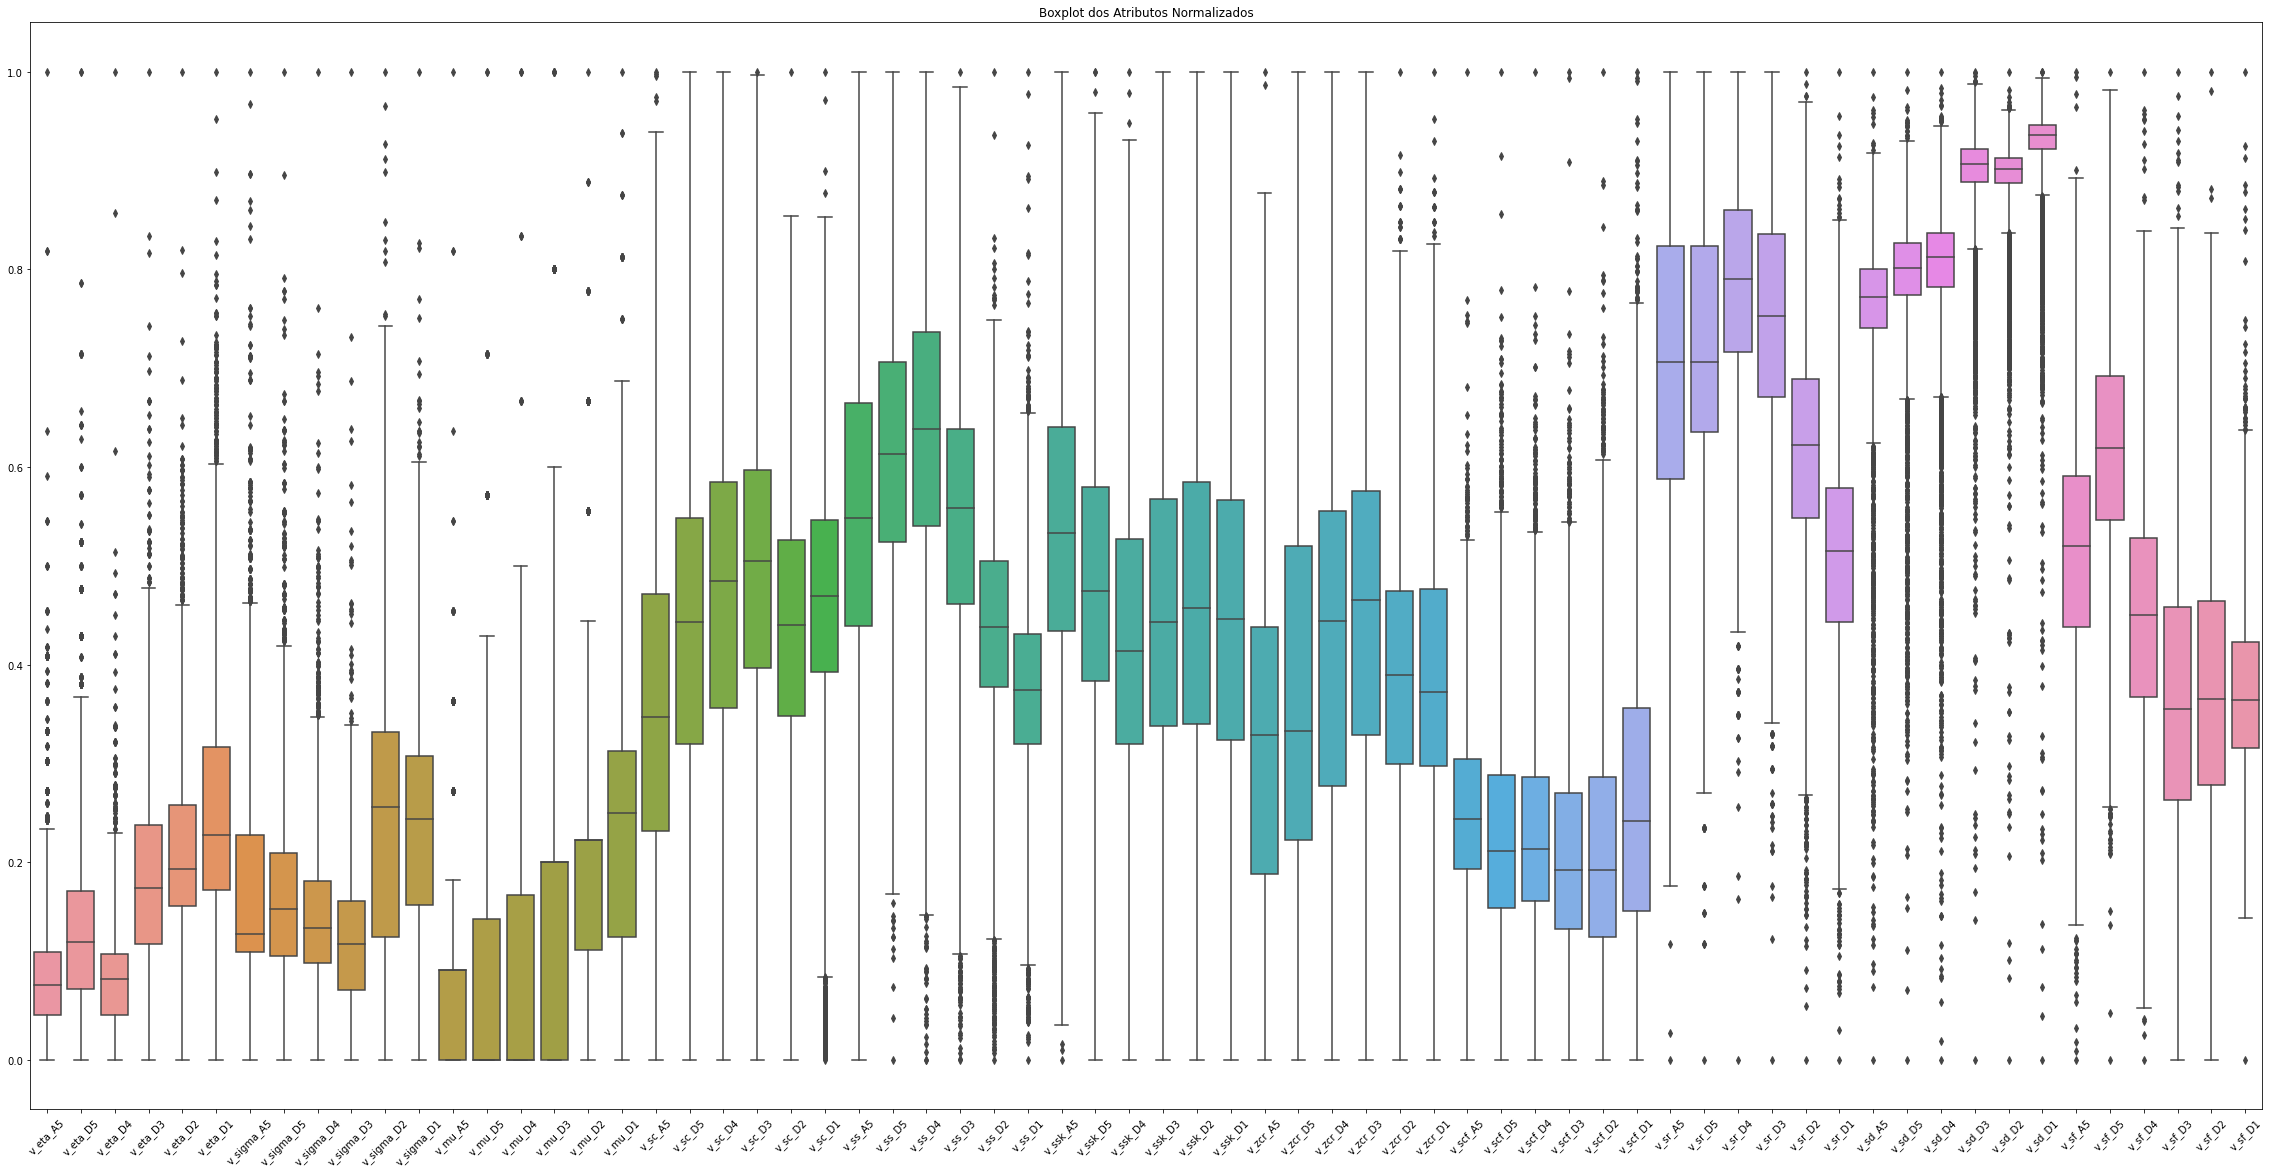

In [103]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(40, 20)
std_data = MinMaxScaler().fit_transform(main_df.iloc[:, :-2])
std_data = pd.DataFrame(std_data, columns = main_df.iloc[:, :-2].columns)
ax = sns.boxplot(data=std_data, orient='v', whis=2)
plt.xticks(rotation=45)

plt.title('Boxplot dos Atributos Normalizados')
plt.savefig('boxplot_norm_atributos.png')

plt.show()

Upper fence= 4.045244637318747


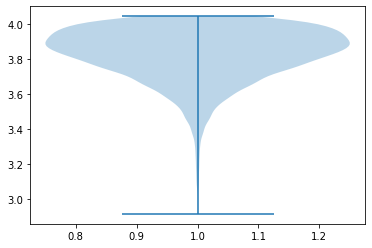

In [104]:
from sklearn.preprocessing import MinMaxScaler


std_data = MinMaxScaler().fit_transform(main_df.iloc[:, :-2])
centroid = np.zeros((66,))

dists=[]

for row in std_data:
    dist = np.linalg.norm(row-centroid)
    dists.append(dist)



s_dists = np.sort(dists)
q1 = s_dists[int(len(s_dists)/4)]
q3 = s_dists[int(len(s_dists)/4) + int(len(s_dists)/2)]
iqr= q3-q1
upper_fence = q3
print("Upper fence= " + str(upper_fence))

spherical_std_data = main_df[dists<=upper_fence]
spherical_std_df = pd.DataFrame(spherical_std_data)
spherical_std_df

plt.violinplot([d for d in dists if d<=upper_fence])
plt.show()

# Distribuição do Banco de Dados

### Treinamento X Validação X Teste

Neste bloco é feita a distribuição do banco de dados em Banco de Treinamento, Banco de Validação e Banco de Teste. Essa distribuição pode ser feita de 3 formas:
 - No formado **Train/Test aleatório** em que é utilizada a API do Scikit-Learn para segmentar o banco de forma completamente aleatória em duas partes apenas: treinamento (75%) e teste (25%), deve ser utilizado para treinamento com `GridSearchCV`;
 - No formato **Train/CV/Test balanceado sem shuffle** em que o banco é segmentado primeiro em respeito aos valores de BPM e, para conjuntos com mais de 10 itens, o conjunto é segmentado para banco de treinamento (70%), validação (15%) e teste (15%), resultando em 3 conjuntos balanceados que podem ser utilizados para treinamento manual;
 - No formato **Train/CV/Test balanceado com shuffle** que procede da mesma forma que o anterior depois de randomizar a sequência do banco de dados, evitando a concentração de músicas do mesmo banco em conjuntos de dados específicos.

Para selecionar a forma desejada, o código inicia com um pedido de valor de entrada que pode ser 0 para o primeiro formato, 1 para o segundo e qualquer outra coisa (inclusive apenas a tecla *enter*) para o terceiro. 

In [4]:
data = pickle.load(open('error_main_df.sav', 'rb')).iloc[:, :-1] #main_df or spherical_std_data or pickle.load(open('error_main_df.sav', 'rb'))
data

v_eta_A5  v_eta_D5  v_eta_D4  v_eta_D3  v_eta_D2  \
database  filename                                                              
acm_mirum 10118334.clip.mp3  2.833333  2.200000  3.181818  2.354839  4.593750   
          10270809.clip.mp3  2.285714  2.266667  2.692308  2.147059  3.945946   
          10332517.clip.mp3  2.666667  2.666667  2.500000  2.920000  2.940000   
          10348303.clip.mp3  3.090909  2.266667  4.125000  3.041667  3.945946   
          10389587.clip.mp3  2.000000  2.538462  2.000000  4.000000  3.585366   
...                               ...       ...       ...       ...       ...   
banco1    94.wav             2.538462  2.461538  3.400000  2.840000  3.986301   
          95.wav             3.750000  2.538462  3.000000  3.736842  3.918919   
          96.wav             2.833333  2.428571  2.571429  2.117647  4.264706   
          97.wav             2.428571  2.125000  2.428571  2.117647  4.235294   
          99.wav             3.500000  2.428571  2.916667  3.136364  3.106383   

                             v_eta_D1  v_sigma_A5  v_sigma_D5  v_sigma_D4  \
database  filename                                                          
acm_mirum 10118334.clip.mp3  9.187500    1.213352    0.400000    0.574960   
          10270809.clip.mp3  7.891892    0.699854    0.442217    0.461538   
          10332517.clip.mp3  3.959459    0.471405    0.471405    0.731925   
          10348303.clip.mp3  5.192982    0.995859    0.442217    1.964529   
          10389587.clip.mp3  5.673077    0.000000    1.082404    0.000000   
...                               ...         ...         ...         ...   
banco1    94.wav             5.705882    0.498519    0.634324    0.663325   
          95.wav             5.745098    0.433013    0.745797    0.852803   
          96.wav             8.500000    1.067187    0.494872    0.622700   
          97.wav             6.125000    0.728431    0.330719    0.728431   
          99.wav             5.214286    0.500000    0.728431    0.953794   

                             v_sigma_D3  ...   v_sd_D2   v_sd_D1   v_sf_A5  \
database  filename                       ...                                 
acm_mirum 10118334.clip.mp3    0.649982  ... -0.023721 -0.007043  0.721463   
          10270809.clip.mp3    0.493031  ... -0.062429 -0.056861  0.716342   
          10332517.clip.mp3    0.271293  ... -0.058653 -0.053484  0.650508   
          10348303.clip.mp3    1.059841  ... -0.040350 -0.025611  0.573808   
          10389587.clip.mp3    0.000000  ... -0.029320 -0.034576  0.684462   
...                                 ...  ...       ...       ...       ...   
banco1    94.wav               0.366606  ... -0.024797 -0.028521  0.672531   
          95.wav               0.440347  ... -0.054363 -0.037688  0.519931   
          96.wav               0.322190  ... -0.062304 -0.055434  0.683548   
          97.wav               0.322190  ... -0.032933 -0.038682  0.693360   
          99.wav               0.919261  ... -0.072486 -0.047873  0.698925   

                              v_sf_D5   v_sf_D4   v_sf_D3   v_sf_D2   v_sf_D1  \
database  filename                                                              
acm_mirum 10118334.clip.mp3  0.690003  0.710161  0.501041  0.604924  0.308860   
          10270809.clip.mp3  0.614350  0.502162  0.446977  0.412124  0.292314   
          10332517.clip.mp3  0.615221  0.558058  0.446767  0.445115  0.247787   
          10348303.clip.mp3  0.692712  0.567320  0.689657  0.614103  0.408099   
          10389587.clip.mp3  0.804930  0.359239  0.367759  0.388223  0.245257   
...                               ...       ...       ...       ...       ...   
banco1    94.wav             0.632480  0.511568  0.385613  0.366589  0.270930   
          95.wav             0.647449  0.496156  0.437015  0.530072  0.344177   
          96.wav             0.706678  0.632906  0.421532  0.384137  0.314319   
          97.wav             0.691660  0.717247  0.418132  0.331272

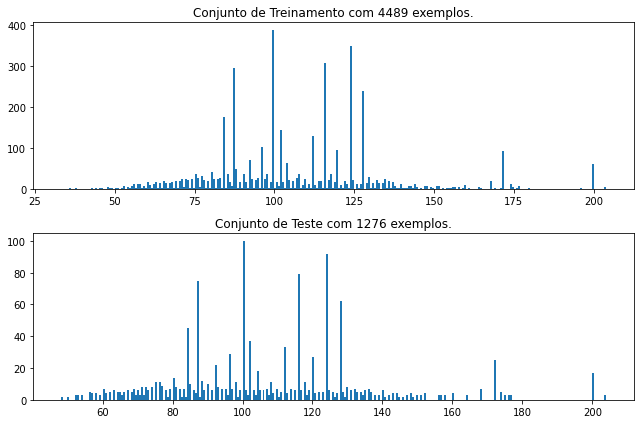

In [5]:
escolha_balanceamento = '1' #input("Digite: \n 0 - Train/Test aleatório \n 1 - Train/CV/Test balanceado sem shuffle \n _ - Train/CV/Test balanceado com shuffle")

X_cv = data
dict = {}

if escolha_balanceamento == '0':

    X = data.iloc[:, :-2]
    y = data.loc[:, ['bpm']]
   
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    y_train = y_train.values.reshape(-1,)
    y_test = y_test.values.reshape(-1,)

    plt.subplot(2,1,1)
    plt.hist(y_train, bins = 273)
    plt.subplot(2,1,2)
    plt.hist(y_test, bins = 273)
    plt.show()

elif escolha_balanceamento == '1':
    
    data = data.sample(frac=1)


    for bpm in data['bpm'].unique():
        dict[bpm] = data[data['bpm'] == bpm]

    train = pd.DataFrame()
    test = pd.DataFrame()


    for label, bpm_list in dict.items():
        if len(bpm_list)<5:
            train = pd.concat([train, bpm_list], axis=0)
        else:
            train_size = int(0.80*len(bpm_list))
            test_size = int(0.20*len(bpm_list))
            
            train_set = bpm_list.iloc[:train_size]
            test_set = bpm_list.iloc[train_size-1:]
            
            train = pd.concat([train, train_set], axis=0)
            test = pd.concat([test, test_set], axis=0)
            
            
    X_train = train.iloc[:, :-2]
    y_train = train.loc[:, ['bpm']]

    X_test = test.iloc[:, :-2]
    y_test = test.loc[:, ['bpm']]


    y_train = y_train.values.reshape(-1,)
    y_test = y_test.values.reshape(-1,)

    fig, ax = plt.subplots(2,1)
    fig.set_size_inches(9, 6)

    
    ax[0].set_title('Conjunto de Treinamento com ' + str(len(y_train)) +' exemplos.')
    ax[0].hist(y_train, bins = 273)
    
    ax[1].set_title('Conjunto de Teste com ' + str(len(y_test)) +' exemplos.')
    ax[1].hist(y_test, bins = 273)

    fig.tight_layout()
    plt.show()


else:
    dict = {}
    if escolha_balanceamento ==  '3':
        pass
    else:
        data = data.sample(frac=1)


    for bpm in data['bpm'].unique():
        dict[bpm] = data[data['bpm'] == bpm]

    train = pd.DataFrame()
    cv = pd.DataFrame()
    test = pd.DataFrame()


    for label, bpm_list in dict.items():
        if(len(bpm_list)<10):
            train = pd.concat([train, bpm_list], axis=0)
        else:
            train_size = int(0.7*len(bpm_list))
            cv_size = int(0.15*len(bpm_list))
            test_size = int(0.15*len(bpm_list))
            
            train_set = bpm_list.iloc[:train_size]
            cv_set = bpm_list.iloc[train_size-1:train_size+cv_size]
            test_set = bpm_list.iloc[train_size+cv_size-1:]
            
            train = pd.concat([train, train_set], axis=0)
            cv = pd.concat([cv, cv_set], axis=0)
            test = pd.concat([test, test_set], axis=0)
            
            
    X_train = train.loc[:, :'v_sf_D1']
    y_train = train.loc[:, ['bpm']]

    X_cv = cv.loc[:, :'v_sf_D1']
    y_cv = cv.loc[:, ['bpm']]

    X_test = test.loc[:, :'v_sf_D1']
    y_test = test.loc[:, ['bpm']]


    y_train = y_train.values.reshape(-1,)
    y_cv = y_cv.values.reshape(-1,)
    y_test = y_test.values.reshape(-1,)

    fig, ax = plt.subplots(3,1)
    fig.set_size_inches(9, 6)

    
    ax[0].set_title('Conjunto de Treinamento com ' + str(len(y_train)) +' exemplos.')
    ax[0].hist(y_train, bins = 273)

    ax[1].set_title('Conjunto de Validação Cruzada')
    ax[1].hist(y_cv, bins = 273)
    
    ax[2].set_title('Conjunto de Teste')
    ax[2].hist(y_test, bins = 273)

    fig.tight_layout()
    plt.show()


### Salvar as imagens separadamente

O bloco abaixo realiza o salvamento dos histogramas de distribuição separadamente para uso no trabalho.

In [4]:
plt.hist(y_train, bins = 273)
plt.title('Conjunto de Treinamento')
plt.savefig('Distribuicao_treinamento.png')
plt.clf()

plt.hist(y_test, bins = 273)
plt.title('Conjunto de Teste')
plt.savefig('Distribuicao_teste.png')
plt.clf()

if escolha_balanceamento != '0' and escolha_balanceamento != '1':
    plt.hist(y_cv, bins = 273)
    plt.title('Conjunto de Validação Cruzada')
    plt.savefig('Distribuicao_validacao.png')
    plt.clf()



<Figure size 432x288 with 0 Axes>

### Separação por atributos e por resoluções DWT

No bloco abaixo é feita a criação e armazenamento dos bancos a serem usados no treinamento

In [6]:
bancos_x ={}

bancos_x['base'] = {'X_train': X_train, 'X_cv': X_cv, 'X_test': X_test}

list_of_col = []
for i in main_df.columns:
    if 'v_eta' in i:
        list_of_col.append(i)
    if 'v_sc' in i:
        list_of_col.append(i)
    if 'v_sf' in i:
        list_of_col.append(i)
    if 'v_sigma' in i:
        list_of_col.append(i)
    if 'v_ssr' in i:
        list_of_col.append(i)

bancos_x['1 e 2 ordem'] = {'X_train': X_train.loc[:, list_of_col], 'X_cv': X_cv.loc[:, list_of_col], 'X_test': X_test.loc[:, list_of_col]}


list_of_col_A5 = []
list_of_col_D5 = []
list_of_col_D4 = []
list_of_col_D3 = []
list_of_col_D2 = []
list_of_col_D1 = []

for i in bancos_x['base']['X_train'].columns:
    if 'A5' in i:
        list_of_col_A5.append(i)
    if 'D5' in i:
        list_of_col_D5.append(i)
    if 'D4' in i:
        list_of_col_D4.append(i)
    if 'D3' in i:
        list_of_col_D3.append(i)
    if 'D2' in i:
        list_of_col_D2.append(i)
    if 'D1' in i:
        list_of_col_D1.append(i)

bancos_x['A5'] = {'X_train': X_train.loc[:, list_of_col_A5], 'X_cv': X_cv.loc[:, list_of_col_A5], 'X_test': X_test.loc[:, list_of_col_A5]}
bancos_x['D5'] = {'X_train': X_train.loc[:, list_of_col_D5], 'X_cv': X_cv.loc[:, list_of_col_D5], 'X_test': X_test.loc[:, list_of_col_D5]}
bancos_x['D4'] = {'X_train': X_train.loc[:, list_of_col_D4], 'X_cv': X_cv.loc[:, list_of_col_D4], 'X_test': X_test.loc[:, list_of_col_D4]}
bancos_x['D3'] = {'X_train': X_train.loc[:, list_of_col_D3], 'X_cv': X_cv.loc[:, list_of_col_D3], 'X_test': X_test.loc[:, list_of_col_D3]}
bancos_x['D2'] = {'X_train': X_train.loc[:, list_of_col_D2], 'X_cv': X_cv.loc[:, list_of_col_D2], 'X_test': X_test.loc[:, list_of_col_D2]}
bancos_x['D1'] = {'X_train': X_train.loc[:, list_of_col_D1], 'X_cv': X_cv.loc[:, list_of_col_D1], 'X_test': X_test.loc[:, list_of_col_D1]}


In [7]:
list_of_col_A5 = []
list_of_col_D5 = []
list_of_col_D4 = []
list_of_col_D3 = []
list_of_col_D2 = []
list_of_col_D1 = []

for i in bancos_x['1 e 2 ordem']['X_train'].columns:
    if 'A5' in i:
        list_of_col_A5.append(i)
    if 'D5' in i:
        list_of_col_D5.append(i)
    if 'D4' in i:
        list_of_col_D4.append(i)
    if 'D3' in i:
        list_of_col_D3.append(i)
    if 'D2' in i:
        list_of_col_D2.append(i)
    if 'D1' in i:
        list_of_col_D1.append(i)
        
bancos_x['A5 1 e 2 ordem'] = {'X_train': bancos_x['1 e 2 ordem']['X_train'].loc[:, list_of_col_A5], 'X_cv': bancos_x['1 e 2 ordem']['X_cv'].loc[:, list_of_col_A5], 'X_test': bancos_x['1 e 2 ordem']['X_test'].loc[:, list_of_col_A5] }
bancos_x['D5 1 e 2 ordem'] = {'X_train': bancos_x['1 e 2 ordem']['X_train'].loc[:, list_of_col_D5], 'X_cv': bancos_x['1 e 2 ordem']['X_cv'].loc[:, list_of_col_D5], 'X_test': bancos_x['1 e 2 ordem']['X_test'].loc[:, list_of_col_D5] }
bancos_x['D4 1 e 2 ordem'] = {'X_train': bancos_x['1 e 2 ordem']['X_train'].loc[:, list_of_col_D4], 'X_cv': bancos_x['1 e 2 ordem']['X_cv'].loc[:, list_of_col_D4], 'X_test': bancos_x['1 e 2 ordem']['X_test'].loc[:, list_of_col_D4] }
bancos_x['D3 1 e 2 ordem'] = {'X_train': bancos_x['1 e 2 ordem']['X_train'].loc[:, list_of_col_D3], 'X_cv': bancos_x['1 e 2 ordem']['X_cv'].loc[:, list_of_col_D3], 'X_test': bancos_x['1 e 2 ordem']['X_test'].loc[:, list_of_col_D3] }
bancos_x['D2 1 e 2 ordem'] = {'X_train': bancos_x['1 e 2 ordem']['X_train'].loc[:, list_of_col_D2], 'X_cv': bancos_x['1 e 2 ordem']['X_cv'].loc[:, list_of_col_D2], 'X_test': bancos_x['1 e 2 ordem']['X_test'].loc[:, list_of_col_D2] }
bancos_x['D1 1 e 2 ordem'] = {'X_train': bancos_x['1 e 2 ordem']['X_train'].loc[:, list_of_col_D1], 'X_cv': bancos_x['1 e 2 ordem']['X_cv'].loc[:, list_of_col_D1], 'X_test': bancos_x['1 e 2 ordem']['X_test'].loc[:, list_of_col_D1] }



# Avaliação da Correlação/Lasso


[-0. -0. -0.  0.  0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0.  0. -0. -0.
 -0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 -0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0. -0. -0. -0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0. -0. -0. -0. -0. -0. -0.]


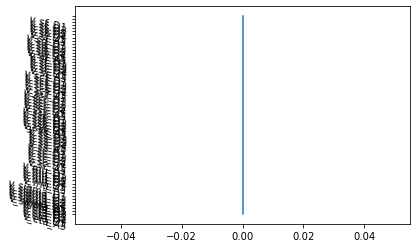

,bpm
count,66.000000
mean,0.022878
std,0.098532
min,-0.198076
25%,-0.038515
50%,0.023133
75%,0.089925
max,0.242611


In [7]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha = 0.4, normalize=True)
lasso.fit(X,y)
print(lasso.coef_)

plt.plot(lasso.coef_, range(len(X.columns)))
plt.yticks(range(len(X.columns)), X.columns, rotation = -15)
plt.show()


main_df.corr().loc[:, ['bpm']].iloc[:-1].describe()

# Treinamento - Tensorflow + keras

In [35]:

inputA5 = keras.layers.Input(shape=bancos_x['A5']['X_train'].shape)
hiddenA5 = keras.layers.Dense(20, activation= 'tanh')(inputA5)
outputA5 = keras.layers.Dense(1)(hiddenA5)

inputD5 = keras.layers.Input(shape=bancos_x['D5']['X_train'].shape)
hiddenD5 = keras.layers.Dense(20, activation= 'tanh')(inputD5)
outputD5 = keras.layers.Dense(1)(hiddenD5)

inputD4 = keras.layers.Input(shape=bancos_x['D4']['X_train'].shape)
hiddenD4 = keras.layers.Dense(20, activation= 'tanh')(inputD4)
outputD4 = keras.layers.Dense(1)(hiddenD4)

inputD3 = keras.layers.Input(shape=bancos_x['D3']['X_train'].shape)
hiddenD3 = keras.layers.Dense(20, activation= 'tanh')(inputD3)
outputD3 = keras.layers.Dense(1)(hiddenD3)

inputD2 = keras.layers.Input(shape=bancos_x['D2']['X_train'].shape)
hiddenD2 = keras.layers.Dense(20, activation= 'tanh')(inputD2)
outputD2 = keras.layers.Dense(1)(hiddenD2)

inputD1 = keras.layers.Input(shape=bancos_x['D1']['X_train'].shape)
hiddenD1 = keras.layers.Dense(20, activation= 'tanh')(inputD1)
outputD1 = keras.layers.Dense(1)(hiddenD1)

concat_input = keras.layers.concatenate([outputA5, outputD5, outputD4, outputD3, outputD2, outputD1])
hidden = keras.layers.Dense(20, activation="tanh")(concat_input)
output = keras.layers.Dense(1)(hidden)
model = keras.models.Model(inputs=[inputA5, inputD5, inputD4, inputD3, inputD2, inputD1], outputs=[output])

model.compile(loss='mean_squared_error', optimizer = 'sgd', metrics=['mean_squared_error'])

model.summary()

ModuleNotFoundError: No module named 'tensorflow.python.trackable'

In [51]:
pd.DataFrame(history.history).iloc[-1]

loss                      1135.839265
mean_squared_error        1135.839355
val_loss                  1031.466521
val_mean_squared_error    1031.466431
Name: 99, dtype: float64

In [71]:
results_df = pd.DataFrame({"Espaço":[],
                           "Alpha":[], "Learning Rate":[],
                           "Layers":[], "Loss":[],
                           "Train_loss":[], "CV_loss":[],
                           "CV_MSE":[], "CV_RMSE":[],
                           "CV_MAPE":[], "Model and History":[]})

mse = keras.metrics.MeanSquaredError()
rmse = keras.metrics.RootMeanSquaredError()
mape = keras.metrics.MeanAbsolutePercentageError()


alphas = [3.e-03, 1.e-01, 1.e-03, 1.e+00, 3.e-01, 1.e+01, 3.e-02, 3.e+02, 1.e+02]
learning_rates = [0.0003, 0.001,  0.003,  0.01,   0.03,   0.3,  0.1]
layer_sizes = np.arange(5,60,5)

params_space = list(product(alphas, learning_rates, layer_sizes))
print(params_space[0])


(0.003, 0.0003, 5, 'mean_squared_error')


In [74]:
#%%time

output_string=''

X_train_std = StandardScaler().fit_transform(X_train)
X_cv_std = StandardScaler().fit_transform(X_cv)
X_test_std = StandardScaler().fit_transform(X_test)

for space_i, space in enumerate(params_space):

	#train
	input_layer = keras.layers.Input(shape=X_train.shape[1:])
	hidden = keras.layers.Dense(space[2], activation="tanh", kernel_regularizer=keras.regularizers.l1(space[0]))(input_layer)
	output = keras.layers.Dense(1)(hidden)
	model = keras.models.Model(inputs=[input_layer], outputs=[output])
	model.compile(loss='mean_squared_error', optimizer = 'sgd', metrics=[mse, rmse, mape])

	optimizer = keras.optimizers.SGD(space[1])
	checkpoint = keras.callbacks.ModelCheckpoint("one_machine_"+str(len(params_space))+"_params.h5", save_best_only=True)
	earlystop = keras.callbacks.EarlyStopping(patience=12, restore_best_weights=True)

	history = model.fit(X_train, y_train, 
						epochs=144, 
						validation_data=(X_cv, y_cv),
						callbacks=[checkpoint, earlystop])

	hist_df = pd.DataFrame(history.history).iloc[-1]

	this_dict = {"Espaço":[], "Model and History":[]}
	this_dict["Espaço"].append(space)
	this_dict["Alpha"]=space[0]
	this_dict["Learning Rate"]=space[1]
	this_dict["Layers"]=space[2]
	this_dict["Loss"]=space[3]
	this_dict["Train_loss"]= hist_df['loss']
	this_dict["CV_loss"]= hist_df['val_loss']
	this_dict["CV_RMSE"]= hist_df['val_root_mean_squared_error']
	this_dict["CV_MAPE"]= hist_df['val_mean_absolute_percentage_error']
	this_dict["Model and History"].append((model, history))
	
	
	results_df = pd.concat([results_df, pd.DataFrame(this_dict)], ignore_index = True)

	clear_output()
	output_string = output_string + f"{space_i}/{len((params_space))} espaços treinados - loss = {hist_df['loss']}  -  cv_loss = {hist_df['val_loss']}\n"
	print(output_string)

clear_output()

0/2079 espaços treinados - loss = 1284.9102675950007  -  cv_loss = 1162.4108411145135
1/2079 espaços treinados - loss = 1284.7259465411582  -  cv_loss = 1156.1203106259447
2/2079 espaços treinados - loss = 1301.4474759631025  -  cv_loss = 1137.6155305014047
3/2079 espaços treinados - loss = 1183.7616927245992  -  cv_loss = 1050.4011646996787
4/2079 espaços treinados - loss = 1252.6787275083607  -  cv_loss = 1113.1671442940408
5/2079 espaços treinados - loss = 1188.2401920487775  -  cv_loss = 1070.5698581057768
6/2079 espaços treinados - loss = 1197.2468348639522  -  cv_loss = 1089.3555668170018
7/2079 espaços treinados - loss = 1182.1582438405196  -  cv_loss = 1109.5272112825317
8/2079 espaços treinados - loss = 1241.9025630089186  -  cv_loss = 1082.3696144015757
9/2079 espaços treinados - loss = 1176.2146464500133  -  cv_loss = 1109.2864682170496
10/2079 espaços treinados - loss = 1203.9222853575402  -  cv_loss = 1078.1423740968594
11/2079 espaços treinados - loss = 1173.6427936478503

KeyboardInterrupt: 

In [76]:
results_df.sort_values('CV_loss')

,Espaço,Alpha,Learning Rate,Layers,Loss,Train_loss,CV_loss,CV_MSE,CV_RMSE,CV_MAPE,Model and History
487,"(0.001, 0.0003, 40, mean_absolute_percentage_e...",0.001,0.0003,40.0,mean_absolute_percentage_error,1154.037129,1044.155011,NaN,32.244625,23.240883,(<tensorflow.python.keras.engine.functional.Fu...
605,"(0.001, 0.03, 20, mean_squared_error)",0.001,0.0300,20.0,mean_squared_error,1187.436382,1045.501171,NaN,32.293697,23.265207,(<tensorflow.python.keras.engine.functional.Fu...
121,"(0.003, 0.01, 35, mean_absolute_percentage_error)",0.003,0.0100,35.0,mean_absolute_percentage_error,1172.394526,1049.871078,NaN,32.214798,23.450447,(<tensorflow.python.keras.engine.functional.Fu...
5,"(0.003, 0.0003, 10, mean_squared_error)",0.003,0.0003,10.0,mean_squared_error,1183.761693,1050.401165,NaN,32.313240,22.920746,(<tensorflow.python.keras.engine.functional.Fu...
525,"(0.001, 0.001, 50, root_mean_squared_error)",0.001,0.0010,50.0,root_mean_squared_error,1114.358820,1054.892540,NaN,32.375534,22.886904,(<tensorflow.python.keras.engine.functional.Fu...
...,...,...,...,...,...,...,...,...,...,...,...
363,"(0.1, 0.01, 55, root_mean_squared_error)",0.100,0.0100,55.0,root_mean_squared_error,1431.108577,2074.315398,NaN,42.900139,31.444786,(<tensorflow.python.keras.engine.functional.Fu...
263,"(0.1, 0.0003, 55, mean_squared_error)",0.100,0.0003,55.0,mean_squared_error,1436.492704,2096.739778,NaN,43.137371,35.353279,(<tensorflow.python.keras.engine.functional.Fu...
422,"(0.1, 0.3, 45, mean_squared_error)",0.100,0.3000,45.0,mean_squared_error,1416.523770,2155.651276,NaN,43.963169,32.752895,(<tensorflow.python.keras.engine.functional.Fu...
33,"(0.003, 0.0003, 55, root_mean_squared_error)",0.003,0.0003,55.0,root_mean_squared_error,1190.493153,2216.853710,NaN,46.937332,34.770645,(<tensorflow.python.keras.engine.functional.Fu...


# Treinamento Manual com Arrays - Scikit-Learn

O treinamento manual com Arrays tem como propósito treinar uma MLP utilizando o Scikit-Learn mas treinando de forma iterativa controlada, ou seja, é utilizado um laço `for` que realiza uma iteração de treinamento por vez com `partial_fit()`. Para realizar a validação cruzada, é definido um espaço de parâmetros `params_space` com todas as diferentes combinações de parâmetros a serem avaliadas.

O primeiro bloco realiza a criação do espaço de hiperparâmetros, enquanto o segundo faz o escalonamento dos bancos de dados e o treinamento propriamente dito. Ao final do segundo bloco é construído um dicionário com todas as informações relevantes de cada iteração para avaliação posterior. O terceiro bloco cria um dicionário `sorted_results_df` com o dicionário criado no segundo bloco ordenado ascendente no valor de R2 para o conjunto de validação e salva o dicionário criado. O quarto bloco lê um dicionário salvo (por padrão o recém criado) e o imprime na tela para avaliação. O quinto e último bloco realiza um agrupamento dos dados do dicionário lido para avaliação.

## Not Now

### 1 - Criação do Espaço de Hiperparâmetros

In [4]:
results_df = pd.DataFrame({"Espaço":[],
                           "Train_loss_array":[], "Train_loss":[],
                           "CV_loss_array":[], "CV_loss":[],
                           "Test_loss_array":[], "Test_loss":[],
                           "num_iter":[], "time_elapsed":[]})




alphas = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300]
learning_rates = [0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
layer_sizes = np.arange(1,30,3)

iter_divisor = 400

params_space = list(product(alphas, learning_rates, layer_sizes))
print(len(params_space))

840


### 2 - Escalonamento, Treinamento e Criação do Dicionário

In [19]:
X_train_std = StandardScaler().fit_transform(X_train)
X_cv_std = StandardScaler().fit_transform(X_cv)
X_test_std = StandardScaler().fit_transform(X_test)


In [ ]:

for space_i, space in enumerate(params_space):
    start = time.time()
    mlp = MLPRegressor(alpha = space[0], learning_rate_init = space[1], hidden_layer_sizes = space[2], warm_start = True)
    train_error = []
    cv_error = []
    test_error = []
    
    times_down = 0
    times_up = 0
    max_iter = -int(iter_divisor*np.log10(space[1]))
    for i in range(max_iter):
        mlp.partial_fit(X_train_std, y_train)
        train_loss = mean_squared_error(mlp.predict(X_train_std), y_train)
        
        if i>0:
            if(train_error[-1] - train_loss)<0.001:
                times_up =  times_up+1
                if times_up >=5:
                    sys.stdout.flush()
                    print(f'Espaço de Parâmetros {space_i}: {space} - Treinamento encerrado por falta de evolução: {i} iterações | erro={round(train_loss,3)}!')
                    break
           
                    
        
        train_error.append(train_loss)
        cv_error.append(mean_squared_error(mlp.predict(X_cv_std), y_cv))
        test_error.append(mean_squared_error(mlp.predict(X_test_std), y_test))
        
        print(f'Espaço de Parâmetros {space_i} {space} - Iterações realizadas: {i}/{max_iter} - Train_loss: {train_loss}', end='\r')
        
        if i==max_iter-1:
            sys.stdout.flush()
            print(f'Espaço de Parâmetros {space_i}: {space} - Treinamento encerrado por máximo de iterações: {max_iter}!')
    
    end = time.time()
    
    
    this_dict = {"Espaço":[], "Layers":[], "Train_loss_array":[], "CV_loss_array":[], "Test_loss_array":[]}
    this_dict["Espaço"].append(space)
    this_dict["Alpha"] = space[0]
    this_dict["Learning Rate"] = space[1]
    this_dict["Layers"].append(space[2])
    this_dict["Train_loss_array"].append(train_error)
    this_dict["Train_loss"] = float(train_error[-1])
    this_dict["CV_loss_array"].append(cv_error)
    this_dict["CV_MSE"] = float(cv_error[-1])
    this_dict["CV_R2"] = r2_score(mlp.predict(X_cv_std), y_cv)
    this_dict["Test_loss_array"].append(test_error)
    this_dict["Test_MSE"] = float(test_error[-1])
    this_dict["Test_R2"] = r2_score(mlp.predict(X_test_std), y_test)
    this_dict["num_iter"] = i
    this_dict["time_elapsed"] = (end-start)/60
    
    
    results_df = pd.concat([results_df, pd.DataFrame(this_dict)], ignore_index = True)

clear_output()

### 3 - Ordenação e Armazenamento em Disco do Dicionário

In [7]:
sorted_results = results_df.sort_values(['CV_R2','num_iter'], ascending = [True, False])

saving_path = 'result_of_'+str(len(params_space))+'_iterations.csv'
sorted_results.to_csv(saving_path)

### 4 - Apresentação de um Dicionário Ordenado (por padrão o recém criado)

In [81]:
sorted_results = pd.read_csv(saving_path)
sorted_results = sorted_results.sort_values(['CV_MSE','num_iter'])

### 5 - Agrupamento e Avaliação dos Resultados

## Current

In [7]:
mlp = MLPRegressor(early_stopping=True)

param_grid = [{
    'alpha': [0.1, 0.3, 1, 3, 10, 30, 50],
    'hidden_layer_sizes': [10,20,30,40,50, 60],
    'learning_rate_init': [0.01, 0.03]
}]

X_t_std = StandardScaler().fit_transform(bancos_x['base']['X_train'])

mlp = MLPRegressor(early_stopping=True)
mlp = GridSearchCV(mlp, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
mlp.fit(X_t_std, y_train)

y_train_pred = mlp.predict(X_t_std)
print('Train MSE= ', mean_squared_error(y_train, y_train_pred))

X_test_std = StandardScaler().fit_transform(bancos_x['base']['X_test'])

y_test_pred = mlp.predict(X_test_std)
print('Test MSE= ', mean_squared_error(y_test, y_test_pred))

Train MSE=  1015.7720544745501
Test MSE=  1082.1323099918018


In [8]:

pd.DataFrame(mlp.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_hidden_layer_sizes,param_learning_rate_init,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
37,1.012698,0.307949,0.000984,0.000017,3,10,0.03,"{'alpha': 3, 'hidden_layer_sizes': 10, 'learni...",-1542.542584,-326.807811,...,-1184.616108,505.109186,1,-971.872429,-1308.242144,-1079.874214,-889.070719,-1030.662536,-1055.944408,141.266331
43,1.629577,0.198786,0.001198,0.000398,3,40,0.03,"{'alpha': 3, 'hidden_layer_sizes': 40, 'learni...",-1514.307435,-396.313505,...,-1189.628829,472.252309,2,-966.417561,-1240.798047,-1087.103752,-915.382369,-906.454702,-1023.231286,126.420683
41,2.060233,0.411218,0.001000,0.000005,3,30,0.03,"{'alpha': 3, 'hidden_layer_sizes': 30, 'learni...",-1507.272081,-359.989076,...,-1189.984522,490.741677,3,-954.037394,-1218.178485,-1052.713682,-908.805758,-870.013122,-1000.749688,124.662194
3,2.547746,1.667431,0.001229,0.000447,0.1,20,0.03,"{'alpha': 0.1, 'hidden_layer_sizes': 20, 'lear...",-1511.647670,-333.366595,...,-1190.439812,491.910482,4,-978.261781,-1189.202744,-1125.397945,-898.874935,-874.776107,-1013.302702,124.110729
17,1.918935,0.155433,0.001582,0.000493,0.3,30,0.03,"{'alpha': 0.3, 'hidden_layer_sizes': 30, 'lear...",-1615.589765,-342.589993,...,-1194.819625,506.798242,5,-945.068565,-1178.547146,-1036.357890,-897.568493,-869.839675,-985.476354,111.890736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,2.214290,0.397842,0.001004,0.000019,50,30,0.01,"{'alpha': 50, 'hidden_layer_sizes': 30, 'learn...",-1905.852108,-421.959885,...,-1299.225523,531.736702,80,-1074.609897,-1338.916478,-1195.234134,-966.189343,-1028.466344,-1120.683239,132.422547
78,2.143884,0.348118,0.000990,0.000010,50,40,0.01,"{'alpha': 50, 'hidden_layer_sizes': 40, 'learn...",-1810.390101,-395.776914,...,-1299.837039,542.074147,81,-1054.096586,-1296.340491,-1188.262651,-1045.017951,-1048.653566,-1126.474249,100.600259
74,2.178977,0.278496,0.000794,0.000397,50,20,0.01,"{'alpha': 50, 'hidden_layer_sizes': 20, 'learn...",-1864.578134,-390.497329,...,-1301.179621,544.515667,82,-1057.170468,-1330.239499,-1207.719311,-1043.038288,-1022.322605,-1132.098034,118.806600
62,2.564501,0.565843,0.001397,0.001018,30,20,0.01,"{'alpha': 30, 'hidden_layer_sizes': 20, 'learn...",-1878.593104,-421.408186,...,-1305.724037,533.264263,83,-1058.765051,-1326.463738,-1182.913015,-1025.768302,-928.785736,-1104.539168,137.537168


In [18]:
X_total = main_df.iloc[:, :-2]
X_total_std = MinMaxScaler().fit_transform(X_total)

y_total = main_df.loc[:, 'bpm']
y_total_pred = mlp.predict(X_total_std)
error = np.square(np.subtract(y_total, y_total_pred))

error_main_df = main_df
error_main_df['erro'] = error
error_main_df

v_eta_A5  v_eta_D5  v_eta_D4  v_eta_D3  v_eta_D2  \
database  filename                                                              
acm_mirum 10118334.clip.mp3  2.833333  2.200000  3.181818  2.354839  4.593750   
          10258351.clip.mp3  2.266667  3.200000  2.615385  3.227273  3.617284   
          10270809.clip.mp3  2.285714  2.266667  2.692308  2.147059  3.945946   
          10332517.clip.mp3  2.666667  2.666667  2.500000  2.920000  2.940000   
          10348303.clip.mp3  3.090909  2.266667  4.125000  3.041667  3.945946   
...                               ...       ...       ...       ...       ...   
banco1    95.wav             3.750000  2.538462  3.000000  3.736842  3.918919   
          96.wav             2.833333  2.428571  2.571429  2.117647  4.264706   
          97.wav             2.428571  2.125000  2.428571  2.117647  4.235294   
          98.wav             3.000000  2.538462  2.916667  3.476190  4.424242   
          99.wav             3.500000  2.428571  2.916667  3.136364  3.106383   

                             v_eta_D1  v_sigma_A5  v_sigma_D5  v_sigma_D4  \
database  filename                                                          
acm_mirum 10118334.clip.mp3  9.187500    1.213352    0.400000    0.574960   
          10258351.clip.mp3  6.444444    0.442217    0.748331    0.624926   
          10270809.clip.mp3  7.891892    0.699854    0.442217    0.461538   
          10332517.clip.mp3  3.959459    0.471405    0.471405    0.731925   
          10348303.clip.mp3  5.192982    0.995859    0.442217    1.964529   
...                               ...         ...         ...         ...   
banco1    95.wav             5.745098    0.433013    0.745797    0.852803   
          96.wav             8.500000    1.067187    0.494872    0.622700   
          97.wav             6.125000    0.728431    0.330719    0.728431   
          98.wav             8.314286    0.632456    1.082404    0.862007   
          99.wav             5.214286    0.500000    0.728431    0.953794   

                             v_sigma_D3  ...   v_sd_D1   v_sf_A5   v_sf_D5  \
database  filename                       ...                                 
acm_mirum 10118334.clip.mp3    0.649982  ... -0.007043  0.721463  0.690003   
          10258351.clip.mp3    0.419070  ... -0.040910  0.720558  0.762754   
          10270809.clip.mp3    0.493031  ... -0.056861  0.716342  0.614350   
          10332517.clip.mp3    0.271293  ... -0.053484  0.650508  0.615221   
          10348303.clip.mp3    1.059841  ... -0.025611  0.573808  0.692712   
...                                 ...  ...       ...       ...       ...   
banco1    95.wav               0.440347  ... -0.037688  0.519931  0.647449   
          96.wav               0.322190  ... -0.055434  0.683548  0.706678   
          97.wav               0.322190  ... -0.038682  0.693360  0.691660   
          98.wav               1.219643  ... -0.017450  0.705853  0.734266   
          99.wav               0.919261  ... -0.047873  0.698925  0.660706   

                              v_sf_D4   v_sf_D3   v_sf_D2   v_sf_D1    bpm  \
database  filename                                                           
acm_mirum 10118334.clip.mp3  0.710161  0.501041  0.604924  0.308860   81.0   
          10258351.clip.mp3  0.526791  0.331555  0.290153  0.160497  234.5   
          10270809.clip.mp3  0.502162  0.446977  0.412124  0.292314   95.0   
          10332517.clip.mp3  0.558058  0.446767  0.445115  0.247787  129.0   
          10348303.clip.mp3  0.567320  0.689657  0.614103  0.408099   90.0   
...                               ...       ...       ...       ...    ...   
banco1    95.wav             0.496156  0.437015  0.530072  0.344177  100.0   
          96.wav             0.632906  0.421532  0.384137  0.314319   88.0   
          97.wav             0.717247  0.418132  0.331272  0.216553   88.0   
          98.wav             0.565840  0.516848  0.410616  0.235306  175.0   
          99.wav      

In [34]:
sorted_error = np.sort(error)
dQ2 = int(len(sorted_error)/2)
dQ1 = int(dQ2/2)
dQ3 = dQ2+dQ1

irq = sorted_error[dQ3] - sorted_error[dQ1]
upper_fence = sorted_error[dQ3] + irq

error_main_df = error_main_df.loc[error_main_df['erro']<=upper_fence]
np.mean(error_main_df['erro'])

pickle.dump(error_main_df, open('error_main_df.sav', 'wb'))

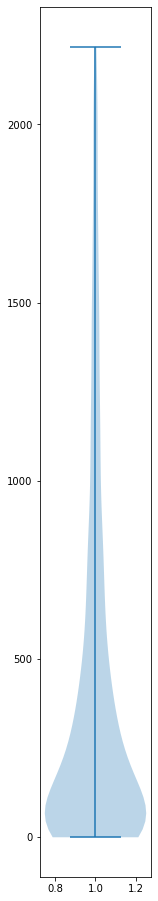

In [29]:

fig, ax = plt.subplots(1,1)
fig.set_size_inches(2, 16)

ax.violinplot(error_main_df['erro'])
plt.show()

base (4489, 66)
base foi treinado


<Figure size 432x288 with 0 Axes>

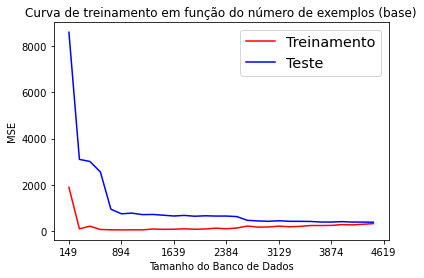

<Figure size 432x288 with 0 Axes>

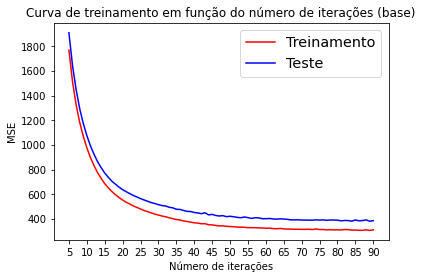

<Figure size 432x288 with 0 Axes>

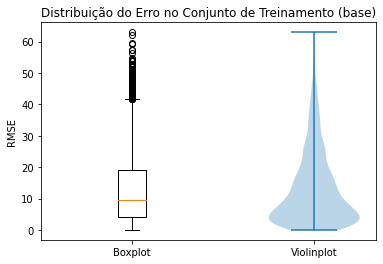

<Figure size 432x288 with 0 Axes>

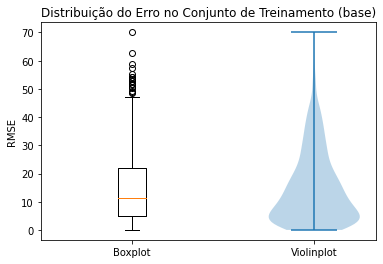

base foi plotado
1 e 2 ordem (4489, 30)
1 e 2 ordem foi treinado


<Figure size 432x288 with 0 Axes>

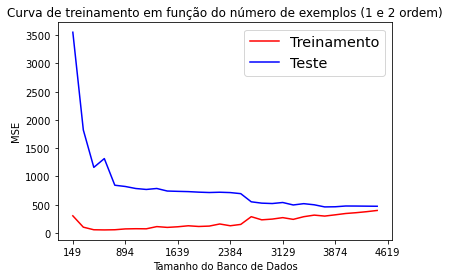

<Figure size 432x288 with 0 Axes>

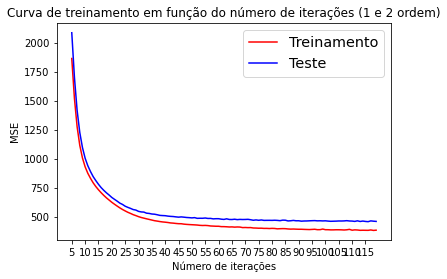

<Figure size 432x288 with 0 Axes>

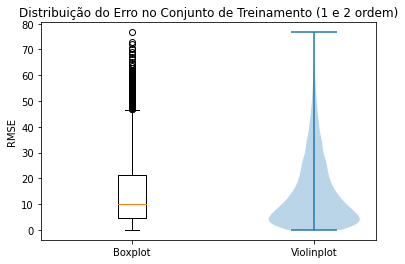

<Figure size 432x288 with 0 Axes>

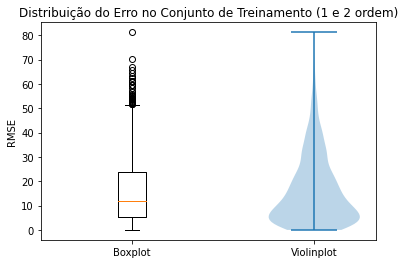

1 e 2 ordem foi plotado
A5 (4489, 11)
A5 foi treinado


<Figure size 432x288 with 0 Axes>

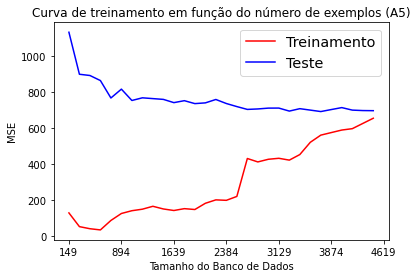

<Figure size 432x288 with 0 Axes>

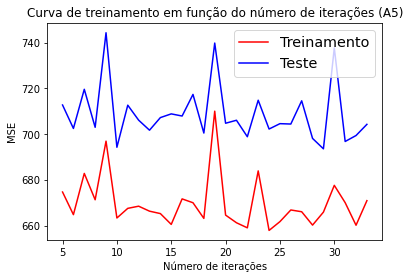

<Figure size 432x288 with 0 Axes>

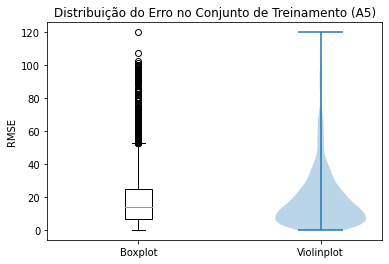

<Figure size 432x288 with 0 Axes>

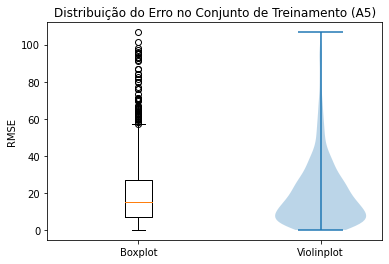

A5 foi plotado
D5 (4489, 11)
D5 foi treinado


<Figure size 432x288 with 0 Axes>

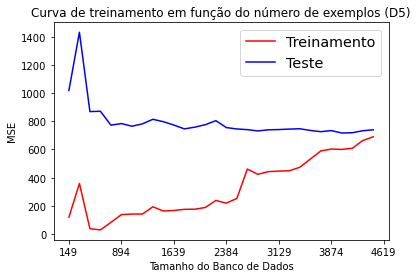

<Figure size 432x288 with 0 Axes>

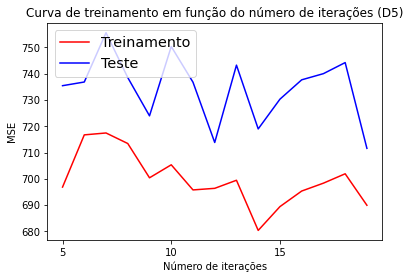

<Figure size 432x288 with 0 Axes>

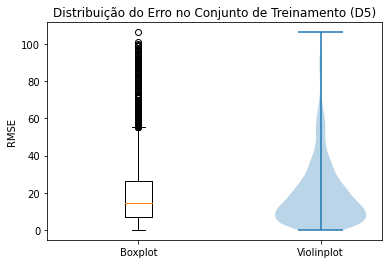

<Figure size 432x288 with 0 Axes>

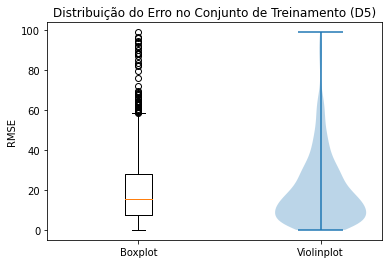

D5 foi plotado
D4 (4489, 11)
D4 foi treinado


<Figure size 432x288 with 0 Axes>

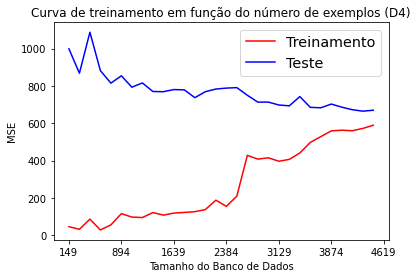

<Figure size 432x288 with 0 Axes>

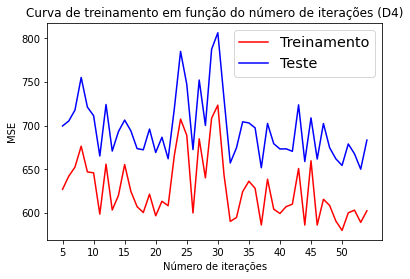

<Figure size 432x288 with 0 Axes>

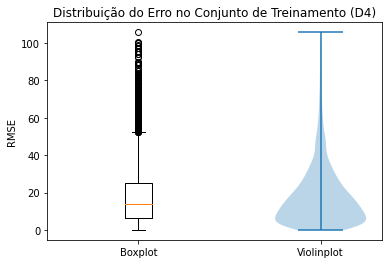

<Figure size 432x288 with 0 Axes>

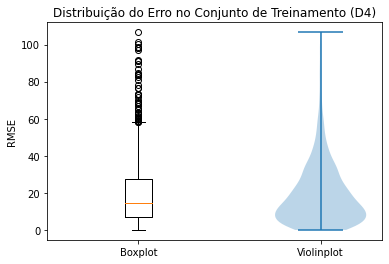

D4 foi plotado
D3 (4489, 11)
D3 foi treinado


<Figure size 432x288 with 0 Axes>

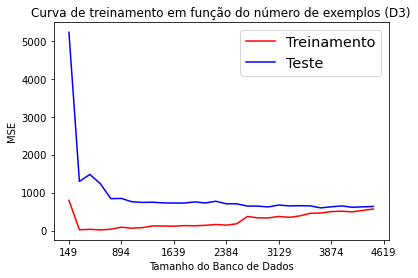

<Figure size 432x288 with 0 Axes>

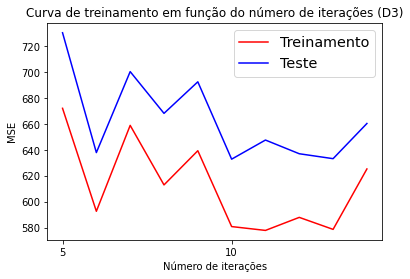

<Figure size 432x288 with 0 Axes>

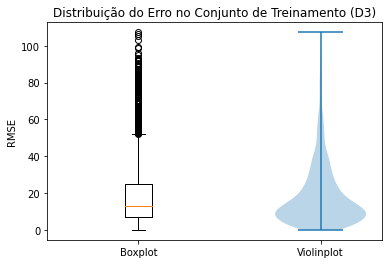

<Figure size 432x288 with 0 Axes>

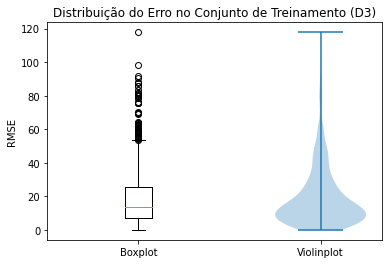

D3 foi plotado
D2 (4489, 11)
D2 foi treinado


<Figure size 432x288 with 0 Axes>

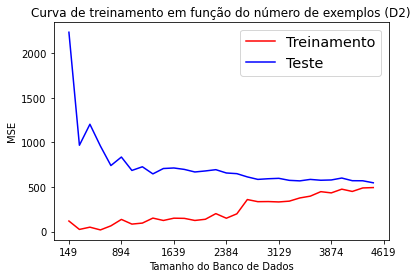

<Figure size 432x288 with 0 Axes>

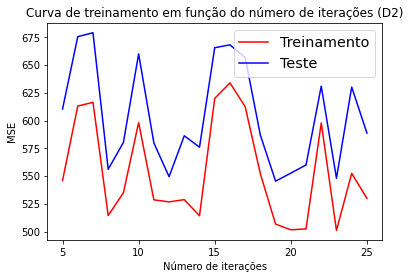

<Figure size 432x288 with 0 Axes>

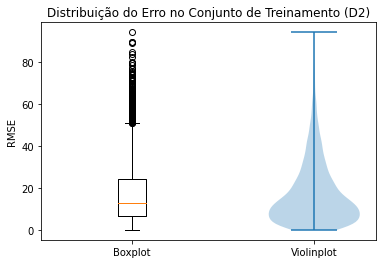

<Figure size 432x288 with 0 Axes>

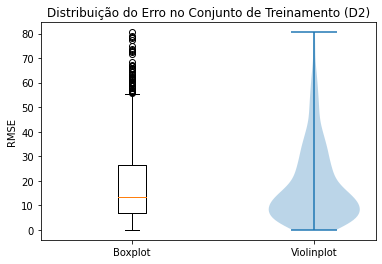

D2 foi plotado
D1 (4489, 11)
D1 foi treinado


<Figure size 432x288 with 0 Axes>

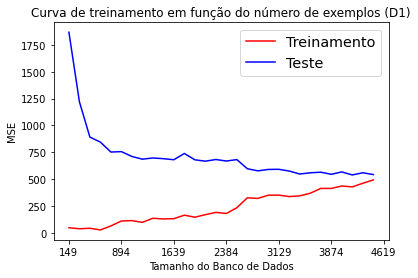

<Figure size 432x288 with 0 Axes>

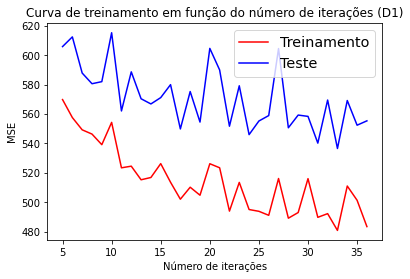

<Figure size 432x288 with 0 Axes>

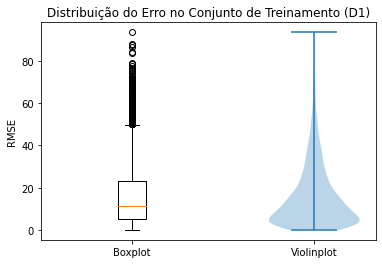

<Figure size 432x288 with 0 Axes>

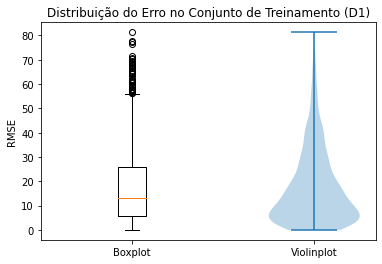

D1 foi plotado
A5 1 e 2 ordem (4489, 5)
A5 1 e 2 ordem foi treinado


<Figure size 432x288 with 0 Axes>

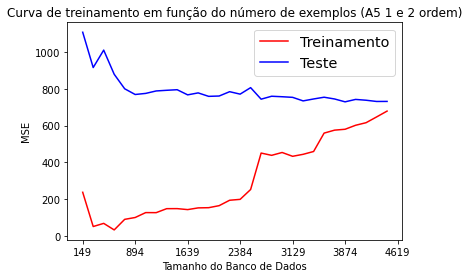

<Figure size 432x288 with 0 Axes>

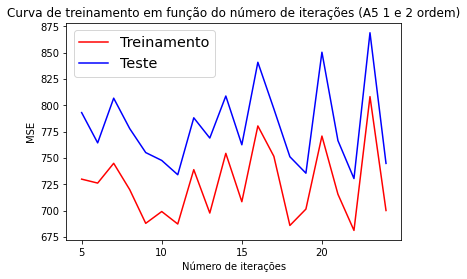

<Figure size 432x288 with 0 Axes>

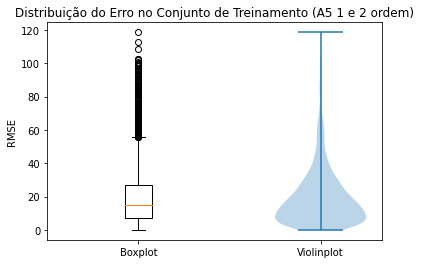

<Figure size 432x288 with 0 Axes>

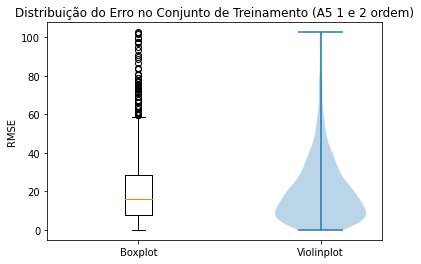

A5 1 e 2 ordem foi plotado
D5 1 e 2 ordem (4489, 5)
D5 1 e 2 ordem foi treinado


<Figure size 432x288 with 0 Axes>

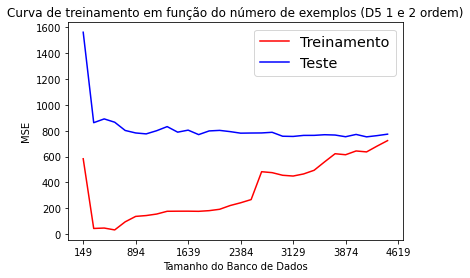

<Figure size 432x288 with 0 Axes>

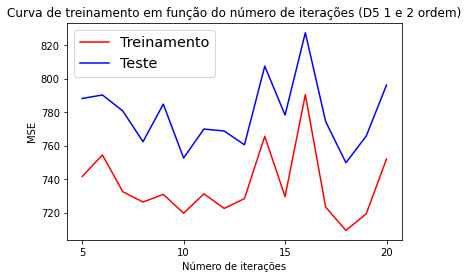

<Figure size 432x288 with 0 Axes>

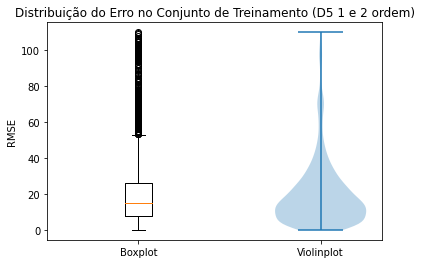

<Figure size 432x288 with 0 Axes>

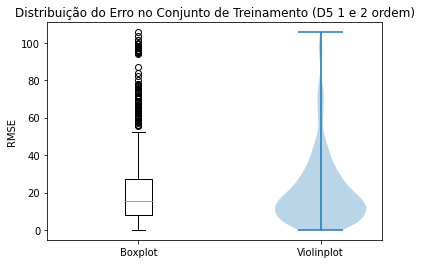

D5 1 e 2 ordem foi plotado
D4 1 e 2 ordem (4489, 5)
D4 1 e 2 ordem foi treinado


<Figure size 432x288 with 0 Axes>

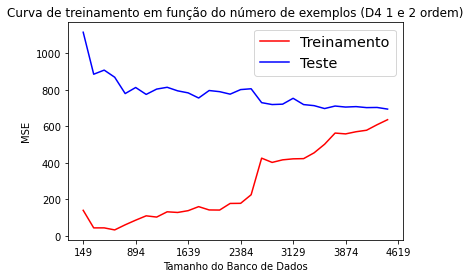

<Figure size 432x288 with 0 Axes>

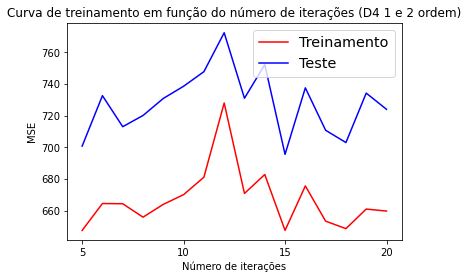

<Figure size 432x288 with 0 Axes>

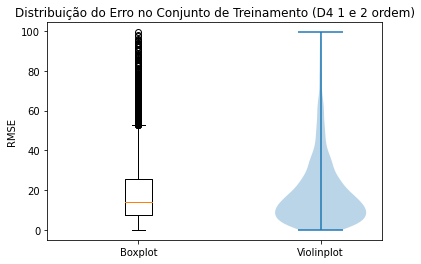

<Figure size 432x288 with 0 Axes>

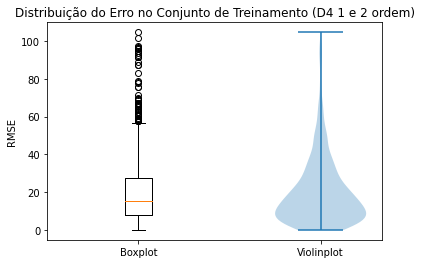

D4 1 e 2 ordem foi plotado
D3 1 e 2 ordem (4489, 5)
D3 1 e 2 ordem foi treinado


<Figure size 432x288 with 0 Axes>

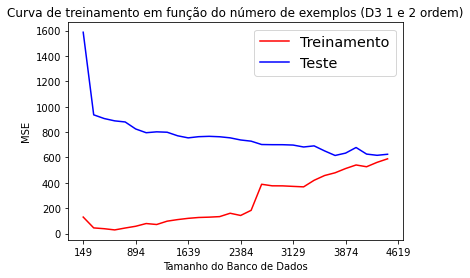

<Figure size 432x288 with 0 Axes>

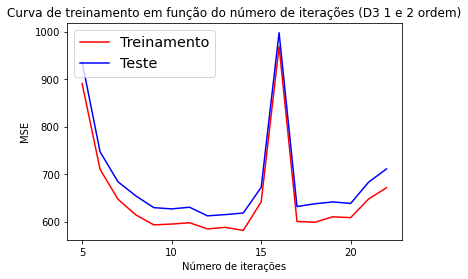

<Figure size 432x288 with 0 Axes>

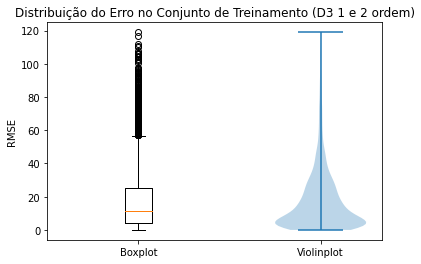

<Figure size 432x288 with 0 Axes>

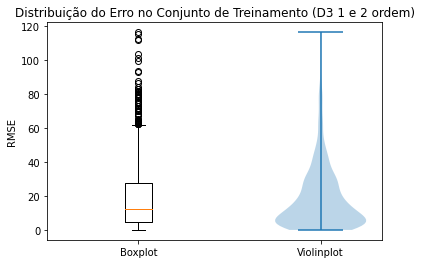

D3 1 e 2 ordem foi plotado
D2 1 e 2 ordem (4489, 5)
D2 1 e 2 ordem foi treinado


<Figure size 432x288 with 0 Axes>

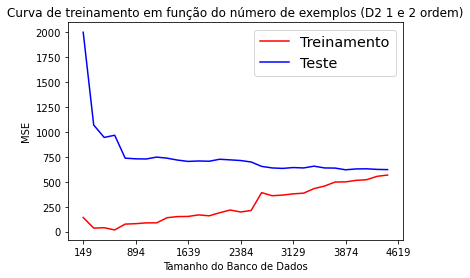

<Figure size 432x288 with 0 Axes>

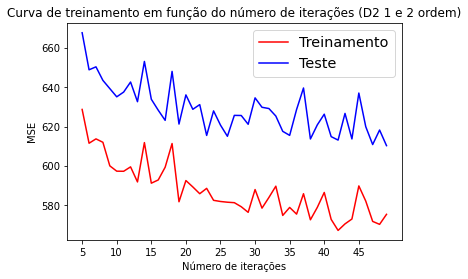

<Figure size 432x288 with 0 Axes>

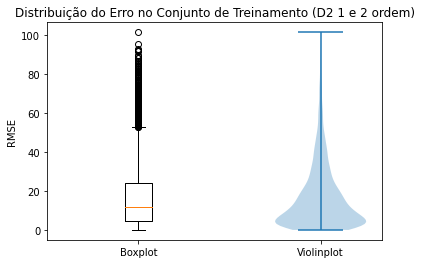

<Figure size 432x288 with 0 Axes>

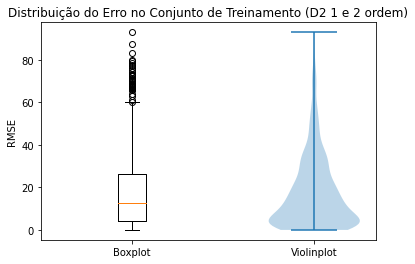

D2 1 e 2 ordem foi plotado
D1 1 e 2 ordem (4489, 5)
D1 1 e 2 ordem foi treinado


<Figure size 432x288 with 0 Axes>

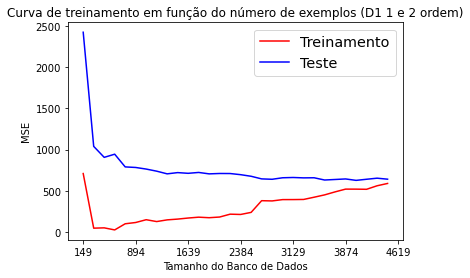

<Figure size 432x288 with 0 Axes>

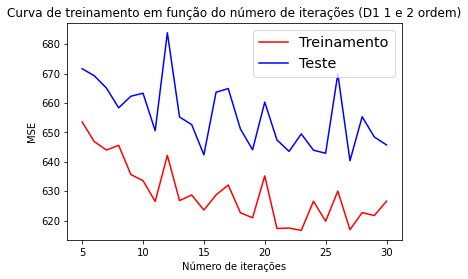

<Figure size 432x288 with 0 Axes>

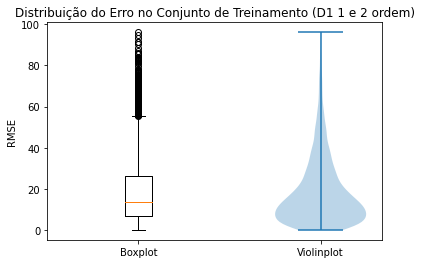

<Figure size 432x288 with 0 Axes>

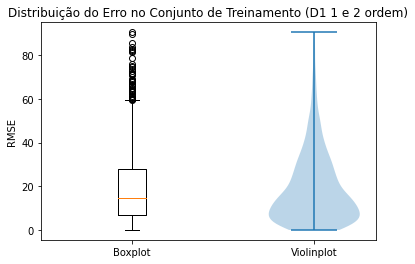

D1 1 e 2 ordem foi plotado
Saidas DWT (4489, 6)
Saidas DWT foi treinado


<Figure size 432x288 with 0 Axes>

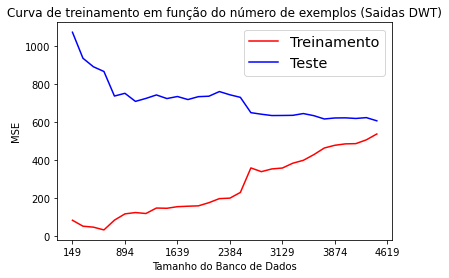

<Figure size 432x288 with 0 Axes>

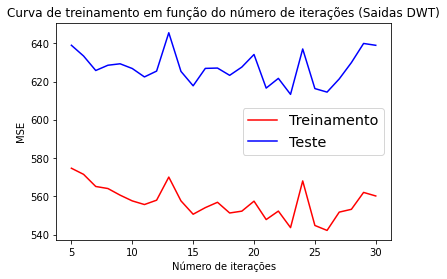

<Figure size 432x288 with 0 Axes>

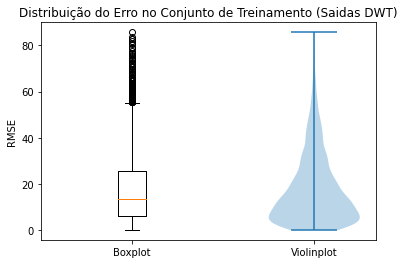

<Figure size 432x288 with 0 Axes>

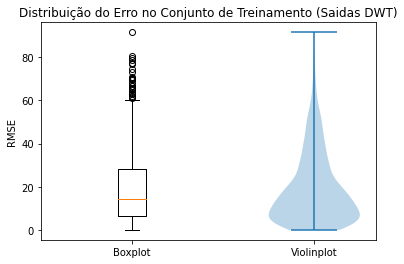

Saidas DWT foi plotado


KeyError: 'X_train'

In [103]:
mlp = MLPRegressor(early_stopping=True)

param_grid = [{
    'alpha': [0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 1, 3, 5, 10, 30, 50, 100],
    'hidden_layer_sizes': [10,20,30,40,50,60],
    'learning_rate_init': [0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5]
}]


for key, value in bancos_x.items():

    print(key, value['X_train'].shape)
    X_t_std = StandardScaler().fit_transform(value['X_train'])

    mlp = MLPRegressor(early_stopping=True)
    mlp = GridSearchCV(mlp, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
    mlp.fit(X_t_std, y_train)

    y_train_pred = mlp.predict(X_t_std)
    bancos_x[key]['Train MSE'] = mean_squared_error(y_train, y_train_pred)
    bancos_x[key]['Train MAE'] = mean_absolute_error(y_train, y_train_pred)
    bancos_x[key]['Train MAPE'] = mean_absolute_percentage_error(y_train, y_train_pred)
    bancos_x[key]['Train R2'] = r2_score(y_train, y_train_pred)


    X_test_std = StandardScaler().fit_transform(value['X_test'])

    y_test_pred = mlp.predict(X_test_std)
    bancos_x[key]['Test MSE'] = mean_squared_error(y_test, y_test_pred)
    bancos_x[key]['Test MAE'] = mean_absolute_error(y_test, y_test_pred)
    bancos_x[key]['Test MAPE'] = mean_absolute_percentage_error(y_test, y_test_pred)
    bancos_x[key]['Test R2'] = r2_score(y_test, y_test_pred)
    
    bancos_x[key]['Model'] = mlp

    #clear_output()
    print(key+' foi treinado')

    

    params = bancos_x[key]['Model'].best_params_

    mlp_def = MLPRegressor(early_stopping=True, alpha=params['alpha'], hidden_layer_sizes=params['hidden_layer_sizes'], learning_rate_init=params['learning_rate_init'])

    X_train_std = StandardScaler().fit_transform(bancos_x[key]['X_train'])
    X_test_std = StandardScaler().fit_transform(bancos_x[key]['X_test'])

    max_size = len(X_train_std)
    iter = int(max_size/30)
    bancos_x[key]['Curva Exemplos Train'] = []
    bancos_x[key]['Curva Exemplos Test'] = []
    n_iter = 0

    for i in range(1,31):
        x_train_i = X_train_std[:i*iter] 
        y_train_i = y_train[:i*iter] 
        mlp=mlp_def
        mlp.fit(x_train_i, y_train_i)

        pred_train_i = mlp.predict(x_train_i)
        erro_train_i = mean_squared_error(pred_train_i, y_train_i)
        bancos_x[key]['Curva Exemplos Train'].append(erro_train_i)

        pred_test_i = mlp.predict(X_test_std)
        erro_test_i = mean_squared_error(pred_test_i, y_test)
        bancos_x[key]['Curva Exemplos Test'].append(erro_test_i)

        if i==30:
            plt.clf()
            fig, ax = plt.subplots()
            ax.set_title('Curva de treinamento em função do número de exemplos ('+key+')')
            ax.plot(bancos_x[key]['Curva Exemplos Train'], color='r', label='Treinamento')
            ax.plot(bancos_x[key]['Curva Exemplos Test'], color='blue', label='Teste')
            ax.set_xlabel('Tamanho do Banco de Dados')
            ax.set_xticks(np.arange(0,31,5))
            ax.set_xticklabels(iter*np.arange(1,32,5))
            ax.set_ylabel('MSE')
            plt.legend(fontsize = 'x-large')
            plt.savefig('img/curva_exemplos_('+key+').png')
            plt.show()

            n_iter = mlp.n_iter_


    bancos_x[key]['Curva Iterações Train'] = []
    bancos_x[key]['Curva Iterações Test'] = []
    mlp = MLPRegressor(warm_start=True, alpha=params['alpha'], hidden_layer_sizes=params['hidden_layer_sizes'], learning_rate_init=params['learning_rate_init'])

    for i in range(0,n_iter+1):
        mlp.partial_fit(X_train_std, y_train)

        pred_train_i = mlp.predict(X_train_std)
        erro_train_i = mean_squared_error(pred_train_i, y_train)
        bancos_x[key]['Curva Iterações Train'].append(erro_train_i)

        pred_test_i = mlp.predict(X_test_std)
        erro_test_i = mean_squared_error(pred_test_i, y_test)
        bancos_x[key]['Curva Iterações Test'].append(erro_test_i)

        if i==n_iter:
            plt.clf()
            fig, ax = plt.subplots()
            ax.set_title('Curva de treinamento em função do número de iterações ('+key+')')
            ax.plot(bancos_x[key]['Curva Iterações Train'][5:], color='r', label='Treinamento')
            ax.plot(bancos_x[key]['Curva Iterações Test'][5:], color='blue', label='Teste')
            ax.set_xlabel('Número de iterações')
            ax.set_xticks(np.arange(0,n_iter-4, 5))
            ax.set_xticklabels(np.arange(5,n_iter+1, 5))
            ax.set_ylabel('MSE')
            plt.legend(fontsize = 'x-large')
            plt.savefig('img/curva_iteracoes_('+key+').png')
            plt.show()



    pred_train = mlp.predict(X_train_std)
    train_error = np.sqrt(np.square(np.subtract(y_train, pred_train)))

    plt.clf()
    fig, ax = plt.subplots()
    ax.set_title('Distribuição do Erro no Conjunto de Treinamento ('+key+')')
    ax.boxplot(train_error, positions=[1])
    ax.violinplot(train_error, positions=[2])
    ax.set_xticks([1,2])
    ax.set_xticklabels(['Boxplot', 'Violinplot'])
    ax.set_ylabel('RMSE')
    plt.savefig('img/erro_treinamento_('+key+').png')
    plt.show()



    pred_test = mlp.predict(X_test_std)
    test_error = np.sqrt(np.square(np.subtract(y_test, pred_test)))

    plt.clf()
    fig, ax = plt.subplots()
    ax.set_title('Distribuição do Erro no Conjunto de Treinamento ('+key+')')
    ax.boxplot(test_error, positions=[1])
    ax.violinplot(test_error, positions=[2])
    ax.set_xticks([1,2])
    ax.set_xticklabels(['Boxplot', 'Violinplot'])
    ax.set_ylabel('RMSE')
    plt.savefig('img/erro_teste_('+key+').png')
    plt.show()

    print(key, 'foi plotado')








dwt_dict = {'yA5': bancos_x['A5']['Model'].predict(bancos_x['A5']['X_train'])}
dwt_dict['yD5'] =  bancos_x['D5']['Model'].predict(bancos_x['D5']['X_train'])
dwt_dict['yD4'] =  bancos_x['D4']['Model'].predict(bancos_x['D4']['X_train'])
dwt_dict['yD3'] =  bancos_x['D3']['Model'].predict(bancos_x['D3']['X_train'])
dwt_dict['yD2'] =  bancos_x['D2']['Model'].predict(bancos_x['D2']['X_train'])
dwt_dict['yD1'] =  bancos_x['D1']['Model'].predict(bancos_x['D1']['X_train'])

dwt_dict_test = {'yA5': bancos_x['A5']['Model'].predict(bancos_x['A5']['X_test'])}
dwt_dict_test['yD5'] =  bancos_x['D5']['Model'].predict(bancos_x['D5']['X_test'])
dwt_dict_test['yD4'] =  bancos_x['D4']['Model'].predict(bancos_x['D4']['X_test'])
dwt_dict_test['yD3'] =  bancos_x['D3']['Model'].predict(bancos_x['D3']['X_test'])
dwt_dict_test['yD2'] =  bancos_x['D2']['Model'].predict(bancos_x['D2']['X_test'])
dwt_dict_test['yD1'] =  bancos_x['D1']['Model'].predict(bancos_x['D1']['X_test'])

bancos_x['Saidas DWT']={'X_train': pd.DataFrame(dwt_dict), 'X_test': pd.DataFrame(dwt_dict_test)}

X_t_std = StandardScaler().fit_transform(bancos_x['Saidas DWT']['X_train'])

mlp_for_grid = MLPRegressor(early_stopping=True)
mlp = GridSearchCV(mlp_for_grid, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True, verbose=4)
mlp.fit(X_t_std, y_train)
bancos_x['Saidas DWT']['Model'] = mlp

y_train_pred = bancos_x['Saidas DWT']['Model'].predict(X_t_std)
bancos_x['Saidas DWT']['Train MSE'] = mean_squared_error(y_train, y_train_pred)
bancos_x['Saidas DWT']['Train MAE'] = mean_absolute_error(y_train, y_train_pred)
bancos_x['Saidas DWT']['Train MAPE'] = mean_absolute_percentage_error(y_train, y_train_pred)
bancos_x['Saidas DWT']['Train R2'] = r2_score(y_train, y_train_pred)

X_test_std = StandardScaler().fit_transform(bancos_x['Saidas DWT']['X_test'])

y_test_pred = bancos_x['Saidas DWT']['Model'].predict(X_test_std)
bancos_x['Saidas DWT']['Test MSE'] = mean_squared_error(y_test, y_test_pred)
bancos_x['Saidas DWT']['Test MAE'] = mean_absolute_error(y_test, y_test_pred)
bancos_x['Saidas DWT']['Test MAPE'] = mean_absolute_percentage_error(y_test, y_test_pred)
bancos_x['Saidas DWT']['Test R2'] = r2_score(y_test, y_test_pred)




predA5 = bancos_x['A5']['Model'].predict(bancos_x['A5']['X_test'])
predD5 = bancos_x['D5']['Model'].predict(bancos_x['D5']['X_test'])
predD4 = bancos_x['D4']['Model'].predict(bancos_x['D4']['X_test'])
predD3 = bancos_x['D3']['Model'].predict(bancos_x['D3']['X_test'])
predD2 = bancos_x['D2']['Model'].predict(bancos_x['D2']['X_test'])
predD1 = bancos_x['D1']['Model'].predict(bancos_x['D1']['X_test'])


pred_DWT = np.array([predA5, predD5, predD4, predD3, predD2, predD1])
pred_ensemble_DWT = np.mean(pred_DWT, axis=0)

bancos_x['Ensemble DWT']={}
bancos_x['Ensemble DWT']['Test MSE'] = mean_squared_error(y_test, pred_ensemble_DWT)
bancos_x['Ensemble DWT']['Test MAE'] = mean_absolute_error(y_test, pred_ensemble_DWT)
bancos_x['Ensemble DWT']['Test MAPE'] = mean_absolute_percentage_error(y_test, pred_ensemble_DWT)
bancos_x['Ensemble DWT']['Test R2'] = r2_score(y_test, pred_ensemble_DWT)

clear_output()
print('Saidas DWT e Ensemble DWT foram treinados')








dwt12_dict = {'yA5 1 e 2 ordem': bancos_x['A5 1 e 2 ordem']['Model'].predict(bancos_x['A5 1 e 2 ordem']['X_train'])}
dwt12_dict['yD5 1 e 2 ordem'] =  bancos_x['D5 1 e 2 ordem']['Model'].predict(bancos_x['D5 1 e 2 ordem']['X_train'])
dwt12_dict['yD4 1 e 2 ordem'] =  bancos_x['D4 1 e 2 ordem']['Model'].predict(bancos_x['D4 1 e 2 ordem']['X_train'])
dwt12_dict['yD3 1 e 2 ordem'] =  bancos_x['D3 1 e 2 ordem']['Model'].predict(bancos_x['D3 1 e 2 ordem']['X_train'])
dwt12_dict['yD2 1 e 2 ordem'] =  bancos_x['D2 1 e 2 ordem']['Model'].predict(bancos_x['D2 1 e 2 ordem']['X_train'])
dwt12_dict['yD1 1 e 2 ordem'] =  bancos_x['D1 1 e 2 ordem']['Model'].predict(bancos_x['D1 1 e 2 ordem']['X_train'])

dwt12_dict_test = {'yA5 1 e 2 ordem': bancos_x['A5 1 e 2 ordem']['Model'].predict(bancos_x['A5 1 e 2 ordem']['X_test'])}
dwt12_dict_test['yD5 1 e 2 ordem'] =  bancos_x['D5 1 e 2 ordem']['Model'].predict(bancos_x['D5 1 e 2 ordem']['X_test'])
dwt12_dict_test['yD4 1 e 2 ordem'] =  bancos_x['D4 1 e 2 ordem']['Model'].predict(bancos_x['D4 1 e 2 ordem']['X_test'])
dwt12_dict_test['yD3 1 e 2 ordem'] =  bancos_x['D3 1 e 2 ordem']['Model'].predict(bancos_x['D3 1 e 2 ordem']['X_test'])
dwt12_dict_test['yD2 1 e 2 ordem'] =  bancos_x['D2 1 e 2 ordem']['Model'].predict(bancos_x['D2 1 e 2 ordem']['X_test'])
dwt12_dict_test['yD1 1 e 2 ordem'] =  bancos_x['D1 1 e 2 ordem']['Model'].predict(bancos_x['D1 1 e 2 ordem']['X_test'])

bancos_x['Saidas DWT 1 e 2 ordem']={'X_train': pd.DataFrame(dwt_dict), 'X_test': pd.DataFrame(dwt_dict_test)}

X_t_std = StandardScaler().fit_transform(bancos_x['Saidas DWT 1 e 2 ordem']['X_train'])

mlp_for_grid = MLPRegressor(early_stopping=True)
mlp = GridSearchCV(mlp_for_grid, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True, verbose=4)
mlp.fit(X_t_std, y_train)
bancos_x['Saidas DWT 1 e 2 ordem']['Model'] = mlp


y_train_pred = bancos_x['Saidas DWT 1 e 2 ordem']['Model'].predict(X_t_std)
bancos_x['Saidas DWT 1 e 2 ordem']['Train MSE'] = mean_squared_error(y_train, y_train_pred)
bancos_x['Saidas DWT 1 e 2 ordem']['Train MAE'] = mean_absolute_error(y_train, y_train_pred)
bancos_x['Saidas DWT 1 e 2 ordem']['Train MAPE'] = mean_absolute_percentage_error(y_train, y_train_pred)
bancos_x['Saidas DWT 1 e 2 ordem']['Train R2'] = r2_score(y_train, y_train_pred)


X_test_std = StandardScaler().fit_transform(bancos_x['Saidas DWT 1 e 2 ordem']['X_test'])

y_test_pred = bancos_x['Saidas DWT 1 e 2 ordem']['Model'].predict(X_test_std)
bancos_x['Saidas DWT 1 e 2 ordem']['Test MSE'] = mean_squared_error(y_test, y_test_pred)
bancos_x['Saidas DWT 1 e 2 ordem']['Test MAE'] = mean_absolute_error(y_test, y_test_pred)
bancos_x['Saidas DWT 1 e 2 ordem']['Test MAPE'] = mean_absolute_percentage_error(y_test, y_test_pred)
bancos_x['Saidas DWT 1 e 2 ordem']['Test R2'] = r2_score(y_test, y_test_pred)

predA5_12 = bancos_x['A5 1 e 2 ordem']['Model'].predict(bancos_x['A5 1 e 2 ordem']['X_test'])
predD5_12 = bancos_x['D5 1 e 2 ordem']['Model'].predict(bancos_x['D5 1 e 2 ordem']['X_test'])
predD4_12 = bancos_x['D4 1 e 2 ordem']['Model'].predict(bancos_x['D4 1 e 2 ordem']['X_test'])
predD3_12 = bancos_x['D3 1 e 2 ordem']['Model'].predict(bancos_x['D3 1 e 2 ordem']['X_test'])
predD2_12 = bancos_x['D2 1 e 2 ordem']['Model'].predict(bancos_x['D2 1 e 2 ordem']['X_test'])
predD1_12 = bancos_x['D1 1 e 2 ordem']['Model'].predict(bancos_x['D1 1 e 2 ordem']['X_test'])

pred_12 = np.array([predA5_12, predD5_12, predD4_12, predD3_12, predD2_12, predD1_12])
pred_ensemble_12 = np.mean(pred_12, axis=0)

bancos_x['Ensemble DWT 1 e 2 ordem']={}
bancos_x['Ensemble DWT 1 e 2 ordem']['Test MSE'] = mean_squared_error(y_test, pred_ensemble_12)
bancos_x['Ensemble DWT 1 e 2 ordem']['Test MAE'] = mean_absolute_error(y_test, pred_ensemble_12)
bancos_x['Ensemble DWT 1 e 2 ordem']['Test MAPE'] = mean_absolute_percentage_error(y_test, pred_ensemble_12)
bancos_x['Ensemble DWT 1 e 2 ordem']['Test R2'] = r2_score(y_test, pred_ensemble_12)

clear_output()
print('Saidas DWT 1 e 2 ordem e Ensemble DWT 1 e 2 ordem foram treinados')




pickle.dump(bancos_x, open('model_bank_error.sav', 'wb'))


<Figure size 432x288 with 0 Axes>

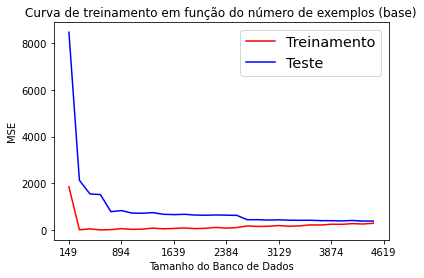

ValueError: The number of FixedLocator locations (13), usually from a call to set_ticks, does not match the number of ticklabels (64).

<Figure size 432x288 with 0 Axes>

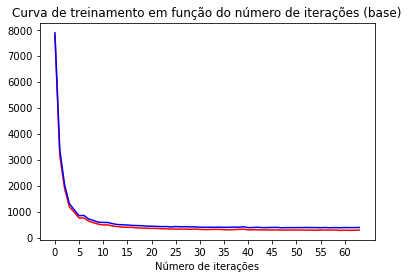

In [74]:


params = bancos_x[key]['Model'].best_params_

mlp_def = MLPRegressor(early_stopping=True, alpha=params['alpha'], hidden_layer_sizes=params['hidden_layer_sizes'], learning_rate_init=params['learning_rate_init'])

X_train_std = StandardScaler().fit_transform(bancos_x[key]['X_train'])
X_test_std = StandardScaler().fit_transform(bancos_x[key]['X_test'])

max_size = len(X_train_std)
iter = int(max_size/30)
bancos_x[key]['Curva Exemplos Train'] = []
bancos_x[key]['Curva Exemplos Test'] = []
n_iter = 0

for i in range(1,31):
    x_train_i = X_train_std[:i*iter] 
    y_train_i = y_train[:i*iter] 
    mlp=mlp_def
    mlp.fit(x_train_i, y_train_i)

    pred_train_i = mlp.predict(x_train_i)
    erro_train_i = mean_squared_error(pred_train_i, y_train_i)
    bancos_x[key]['Curva Exemplos Train'].append(erro_train_i)

    pred_test_i = mlp.predict(X_test_std)
    erro_test_i = mean_squared_error(pred_test_i, y_test)
    bancos_x[key]['Curva Exemplos Test'].append(erro_test_i)

    if i==30:
        plt.clf()
        fig, ax = plt.subplots()
        ax.set_title('Curva de treinamento em função do número de exemplos ('+key+')')
        ax.plot(bancos_x[key]['Curva Exemplos Train'], color='r', label='Treinamento')
        ax.plot(bancos_x[key]['Curva Exemplos Test'], color='blue', label='Teste')
        ax.set_xlabel('Tamanho do Banco de Dados')
        ax.set_xticks(np.arange(0,31,5))
        ax.set_xticklabels(iter*np.arange(1,32,5))
        ax.set_ylabel('MSE')
        plt.legend(fontsize = 'x-large')
        plt.savefig('img/curva_exemplos_('+key+').png')
        plt.show()

        n_iter = mlp.n_iter_


bancos_x[key]['Curva Iterações Train'] = []
bancos_x[key]['Curva Iterações Test'] = []
mlp = MLPRegressor(warm_start=True, alpha=params['alpha'], hidden_layer_sizes=params['hidden_layer_sizes'], learning_rate_init=params['learning_rate_init'])

for i in range(0,n_iter+1):
    mlp.partial_fit(X_train_std, y_train)

    pred_train_i = mlp.predict(X_train_std)
    erro_train_i = mean_squared_error(pred_train_i, y_train)
    bancos_x[key]['Curva Iterações Train'].append(erro_train_i)

    pred_test_i = mlp.predict(X_test_std)
    erro_test_i = mean_squared_error(pred_test_i, y_test)
    bancos_x[key]['Curva Iterações Test'].append(erro_test_i)

    if i==n_iter:
        plt.clf()
        fig, ax = plt.subplots()
        ax.set_title('Curva de treinamento em função do número de iterações ('+key+')')
        ax.plot(bancos_x[key]['Curva Iterações Train'][5:], color='r', label='Treinamento')
        ax.plot(bancos_x[key]['Curva Iterações Test'][5:], color='blue', label='Teste')
        ax.set_xlabel('Número de iterações')
        ax.set_xticks(np.arange(0,n_iter-4, 5))
        ax.set_xticklabels(np.arange(5,n_iter+1, 5))
        ax.set_ylabel('MSE')
        plt.legend(fontsize = 'x-large')
        plt.savefig('img/curva_iteracoes_('+key+').png')
        plt.show()



pred_train = mlp.predict(X_train_std)
train_error = np.sqrt(np.square(np.subtract(y_train, pred_train)))

plt.clf()
fig, ax = plt.subplots()
ax.set_title('Distribuição do Erro no Conjunto de Treinamento ('+key+')')
ax.boxplot(train_error, positions=[1])
ax.violinplot(train_error, positions=[2])
ax.set_xticks([1,2])
ax.set_xticklabels(['Boxplot', 'Violinplot'])
ax.set_ylabel('RMSE')
plt.savefig('img/erro_treinamento_('+key+').png')
plt.show()



pred_test = mlp.predict(X_test_std)
test_error = np.sqrt(np.square(np.subtract(y_test, pred_test)))

plt.clf()
fig, ax = plt.subplots()
ax.set_title('Distribuição do Erro no Conjunto de Treinamento ('+key+')')
ax.boxplot(test_error, positions=[1])
ax.violinplot(test_error, positions=[2])
ax.set_xticks([1,2])
ax.set_xticklabels(['Boxplot', 'Violinplot'])
ax.set_ylabel('RMSE')
plt.savefig('img/erro_teste_('+key+').png')
plt.show()

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

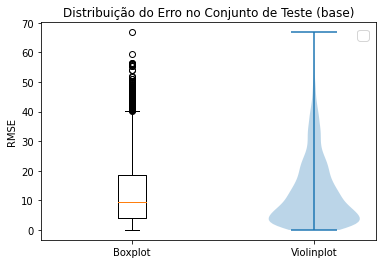

In [102]:

pred_train = mlp.predict(X_train_std)
error = np.sqrt(np.square(np.subtract(y_train, pred_train)))

plt.clf()
fig, ax = plt.subplots()
ax.set_title('Distribuição do Erro no Conjunto de Teste ('+key+')')
ax.boxplot(error, positions=[1])
ax.violinplot(error, positions=[2])
ax.set_xticks([1,2])
ax.set_xticklabels(['Boxplot', 'Violinplot'])
ax.set_ylabel('RMSE')
plt.legend(fontsize = 'x-large')
plt.show()